# Assignment 1 — Experimental Linear Regression (California Housing)

- Name: Umer Farooq
- Roll No: 22I-0891
- Section: CS-7B

This notebook follows the assignment phases. Phase 1 implements dataset loading from scikit-learn without using Pandas and displays features/targets as arrays alongside headers and a table-like printout.


In [27]:
# Imports allowed (no pandas)
import numpy as np
from typing import List
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_california_housing
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.model_selection import KFold, cross_validate

# Configure matplotlib for high-quality publication-ready plots
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 13
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3
plt.rcParams['grid.linestyle'] = '--'

In [28]:
# Global helpers: metrics computation + pretty table (no pandas)
def compute_metrics(y_true, y_pred):
    mse = float(np.mean((y_true - y_pred) ** 2))
    rmse = float(np.sqrt(mse))
    mae = float(np.mean(np.abs(y_true - y_pred)))
    y_mean = float(np.mean(y_true))
    ss_res = float(np.sum((y_true - y_pred) ** 2))
    ss_tot = float(np.sum((y_true - y_mean) ** 2))
    r2 = 1.0 - (ss_res / ss_tot) if ss_tot != 0.0 else 0.0
    return dict(MSE=mse, RMSE=rmse, MAE=mae, R2=r2)

def print_pretty_table(headers, rows):
    col_widths = [len(h) for h in headers]
    for row in rows:
        for j, cell in enumerate(row):
            col_widths[j] = max(col_widths[j], len(str(cell)))
    print(" | ".join(h.ljust(col_widths[i]) for i, h in enumerate(headers)))
    print("-+-".join("-" * w for w in col_widths))
    for row in rows:
        print(" | ".join(str(cell).ljust(col_widths[j]) for j, cell in enumerate(row)))

## Phase 1 — Dataset Loading (No Pandas)

Requirements:
- Load California Housing dataset from scikit-learn (no Pandas)
- Show features (X) and target (y) in array form
- Show headers of features and combine them with feature values for better analysis
- Print feature headers with their values in a table-like format without converting to a DataFrame


In [29]:
# Utility: pretty-print a 2D array with headers (without pandas)
def print_table_with_headers(headers: List[str], values: np.ndarray, max_rows: int = 10) -> None:
    assert values.ndim == 2, "values must be 2D"
    # Compute column widths
    str_headers = [str(h) for h in headers]
    col_widths = [len(h) for h in str_headers]
    for col_idx in range(values.shape[1]):
        # consider up to max_rows for width calculation for performance
        sample = values[:max_rows, col_idx]
        max_val_width = max(len(f"{v:.6g}") for v in sample)
        col_widths[col_idx] = max(col_widths[col_idx], max_val_width)

    # Header line
    header_line = " | ".join(h.ljust(col_widths[i]) for i, h in enumerate(str_headers))
    sep_line = "-+-".join("-" * w for w in col_widths)
    print(header_line)
    print(sep_line)

    # Data rows
    num_rows = min(max_rows, values.shape[0])
    for row_idx in range(num_rows):
        row = values[row_idx]
        row_str = " | ".join(f"{row[col_idx]:.{6}g}".ljust(col_widths[col_idx]) for col_idx in range(values.shape[1]))
        print(row_str)
    if values.shape[0] > max_rows:
        print(f"... ({values.shape[0] - max_rows} more rows not shown)")

# Load dataset (no pandas)
california = fetch_california_housing()
X: np.ndarray = california.data  # shape: (n_samples, n_features)
y: np.ndarray = california.target  # shape: (n_samples,)
feature_names: List[str] = california.feature_names

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"Feature names: {feature_names}")

# Combine headers with values: show first 10 rows in table-like format
print("\nFirst 10 rows of features (table-like):")
print_table_with_headers(feature_names, X, max_rows=10)

# Show first 10 target values as an array
print("\nFirst 10 target values (Median House Value in 100k USD):")
print(y[:10])


X shape: (20640, 8)
y shape: (20640,)
Feature names: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']

First 10 rows of features (table-like):
MedInc | HouseAge | AveRooms | AveBedrms | Population | AveOccup | Latitude | Longitude
-------+----------+----------+-----------+------------+----------+----------+----------
8.3252 | 41       | 6.98413  | 1.02381   | 322        | 2.55556  | 37.88    | -122.23  
8.3014 | 21       | 6.23814  | 0.97188   | 2401       | 2.10984  | 37.86    | -122.22  
7.2574 | 52       | 8.28814  | 1.07345   | 496        | 2.80226  | 37.85    | -122.24  
5.6431 | 52       | 5.81735  | 1.07306   | 558        | 2.54795  | 37.85    | -122.25  
3.8462 | 52       | 6.28185  | 1.08108   | 565        | 2.18147  | 37.85    | -122.25  
4.0368 | 52       | 4.76166  | 1.10363   | 413        | 2.1399   | 37.85    | -122.25  
3.6591 | 52       | 4.93191  | 0.951362  | 1094       | 2.1284   | 37.84    | -122.25  
3.12   | 52    

## Phase 2 — Exploratory Data Analysis (EDA)

We compute NumPy-based descriptive statistics, detect skewness for each feature, visualize distributions (histograms, boxplots), and analyze correlations (feature–feature and feature–target), including a heatmap.


Descriptive Statistics (per feature):
    MedInc | mean=3.8707, median=3.5348, min=0.4999, max=15.0001, std=1.8998
  HouseAge | mean=28.6395, median=29.0000, min=1.0000, max=52.0000, std=12.5853
  AveRooms | mean=5.4290, median=5.2291, min=0.8462, max=141.9091, std=2.4741
 AveBedrms | mean=1.0967, median=1.0488, min=0.3333, max=34.0667, std=0.4739
Population | mean=1425.4767, median=1166.0000, min=3.0000, max=35682.0000, std=1132.4347
  AveOccup | mean=3.0707, median=2.8181, min=0.6923, max=1243.3333, std=10.3858
  Latitude | mean=35.6319, median=34.2600, min=32.5400, max=41.9500, std=2.1359
 Longitude | mean=-119.5697, median=-118.4900, min=-124.3500, max=-114.3100, std=2.0035

Skewness per feature:
    MedInc | skewness=1.6465
  HouseAge | skewness=0.0603
  AveRooms | skewness=20.6964
 AveBedrms | skewness=31.3147
Population | skewness=4.9355
  AveOccup | skewness=97.6325
  Latitude | skewness=0.4659
 Longitude | skewness=-0.2978


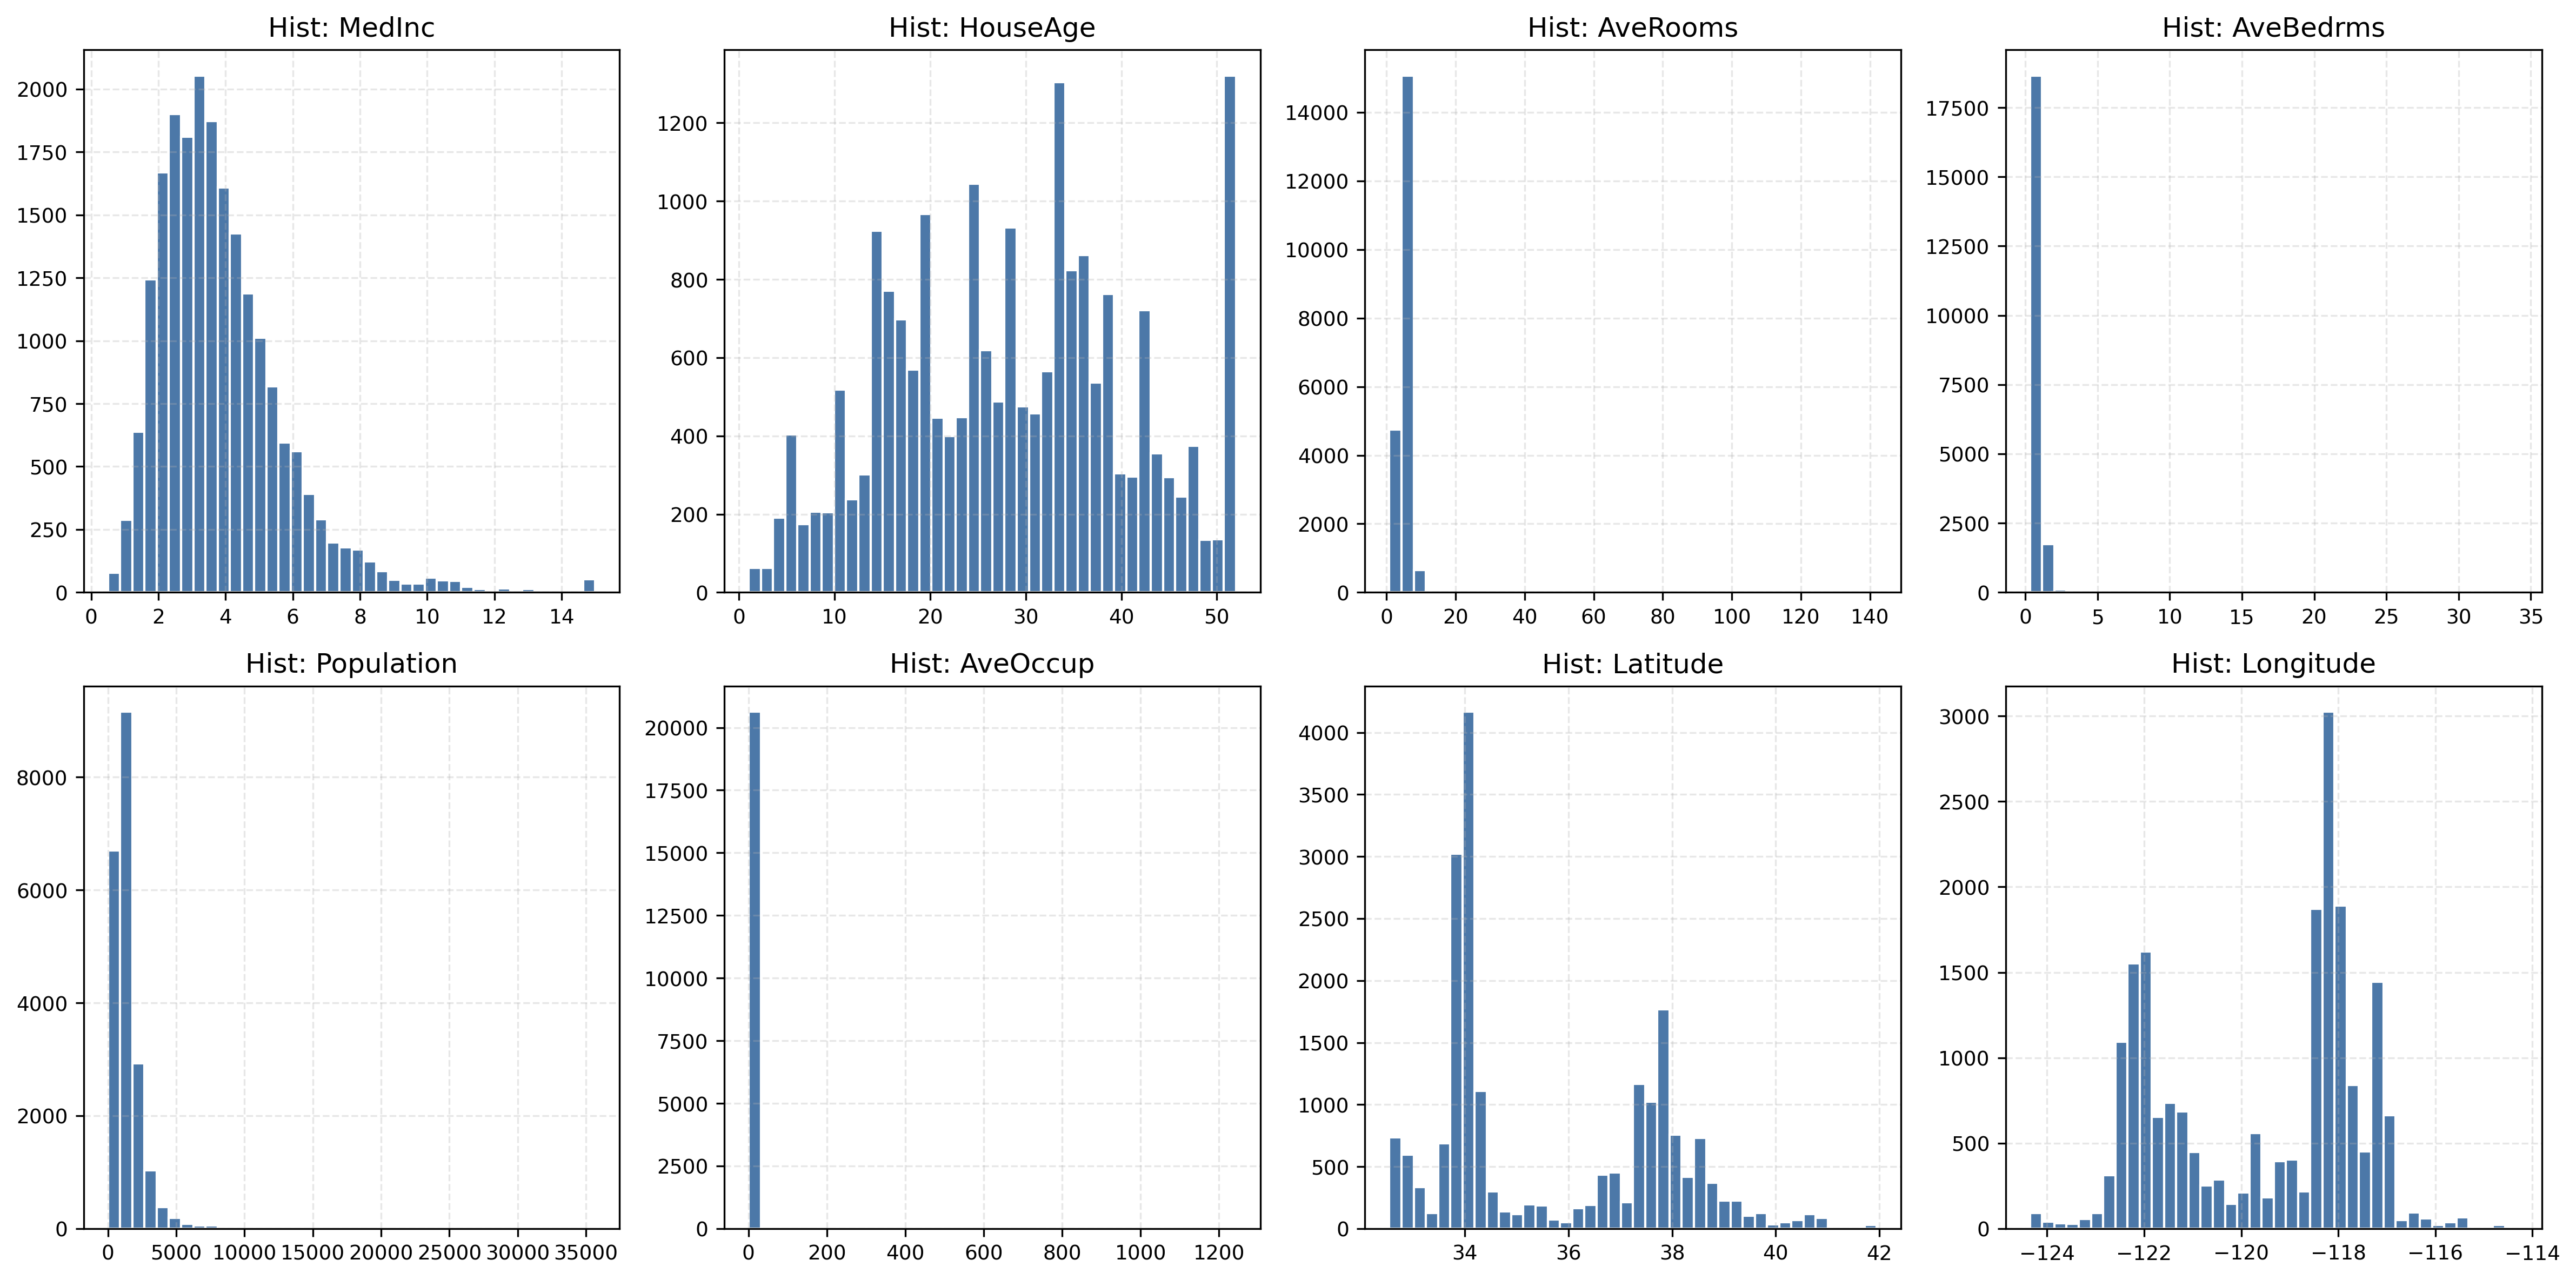

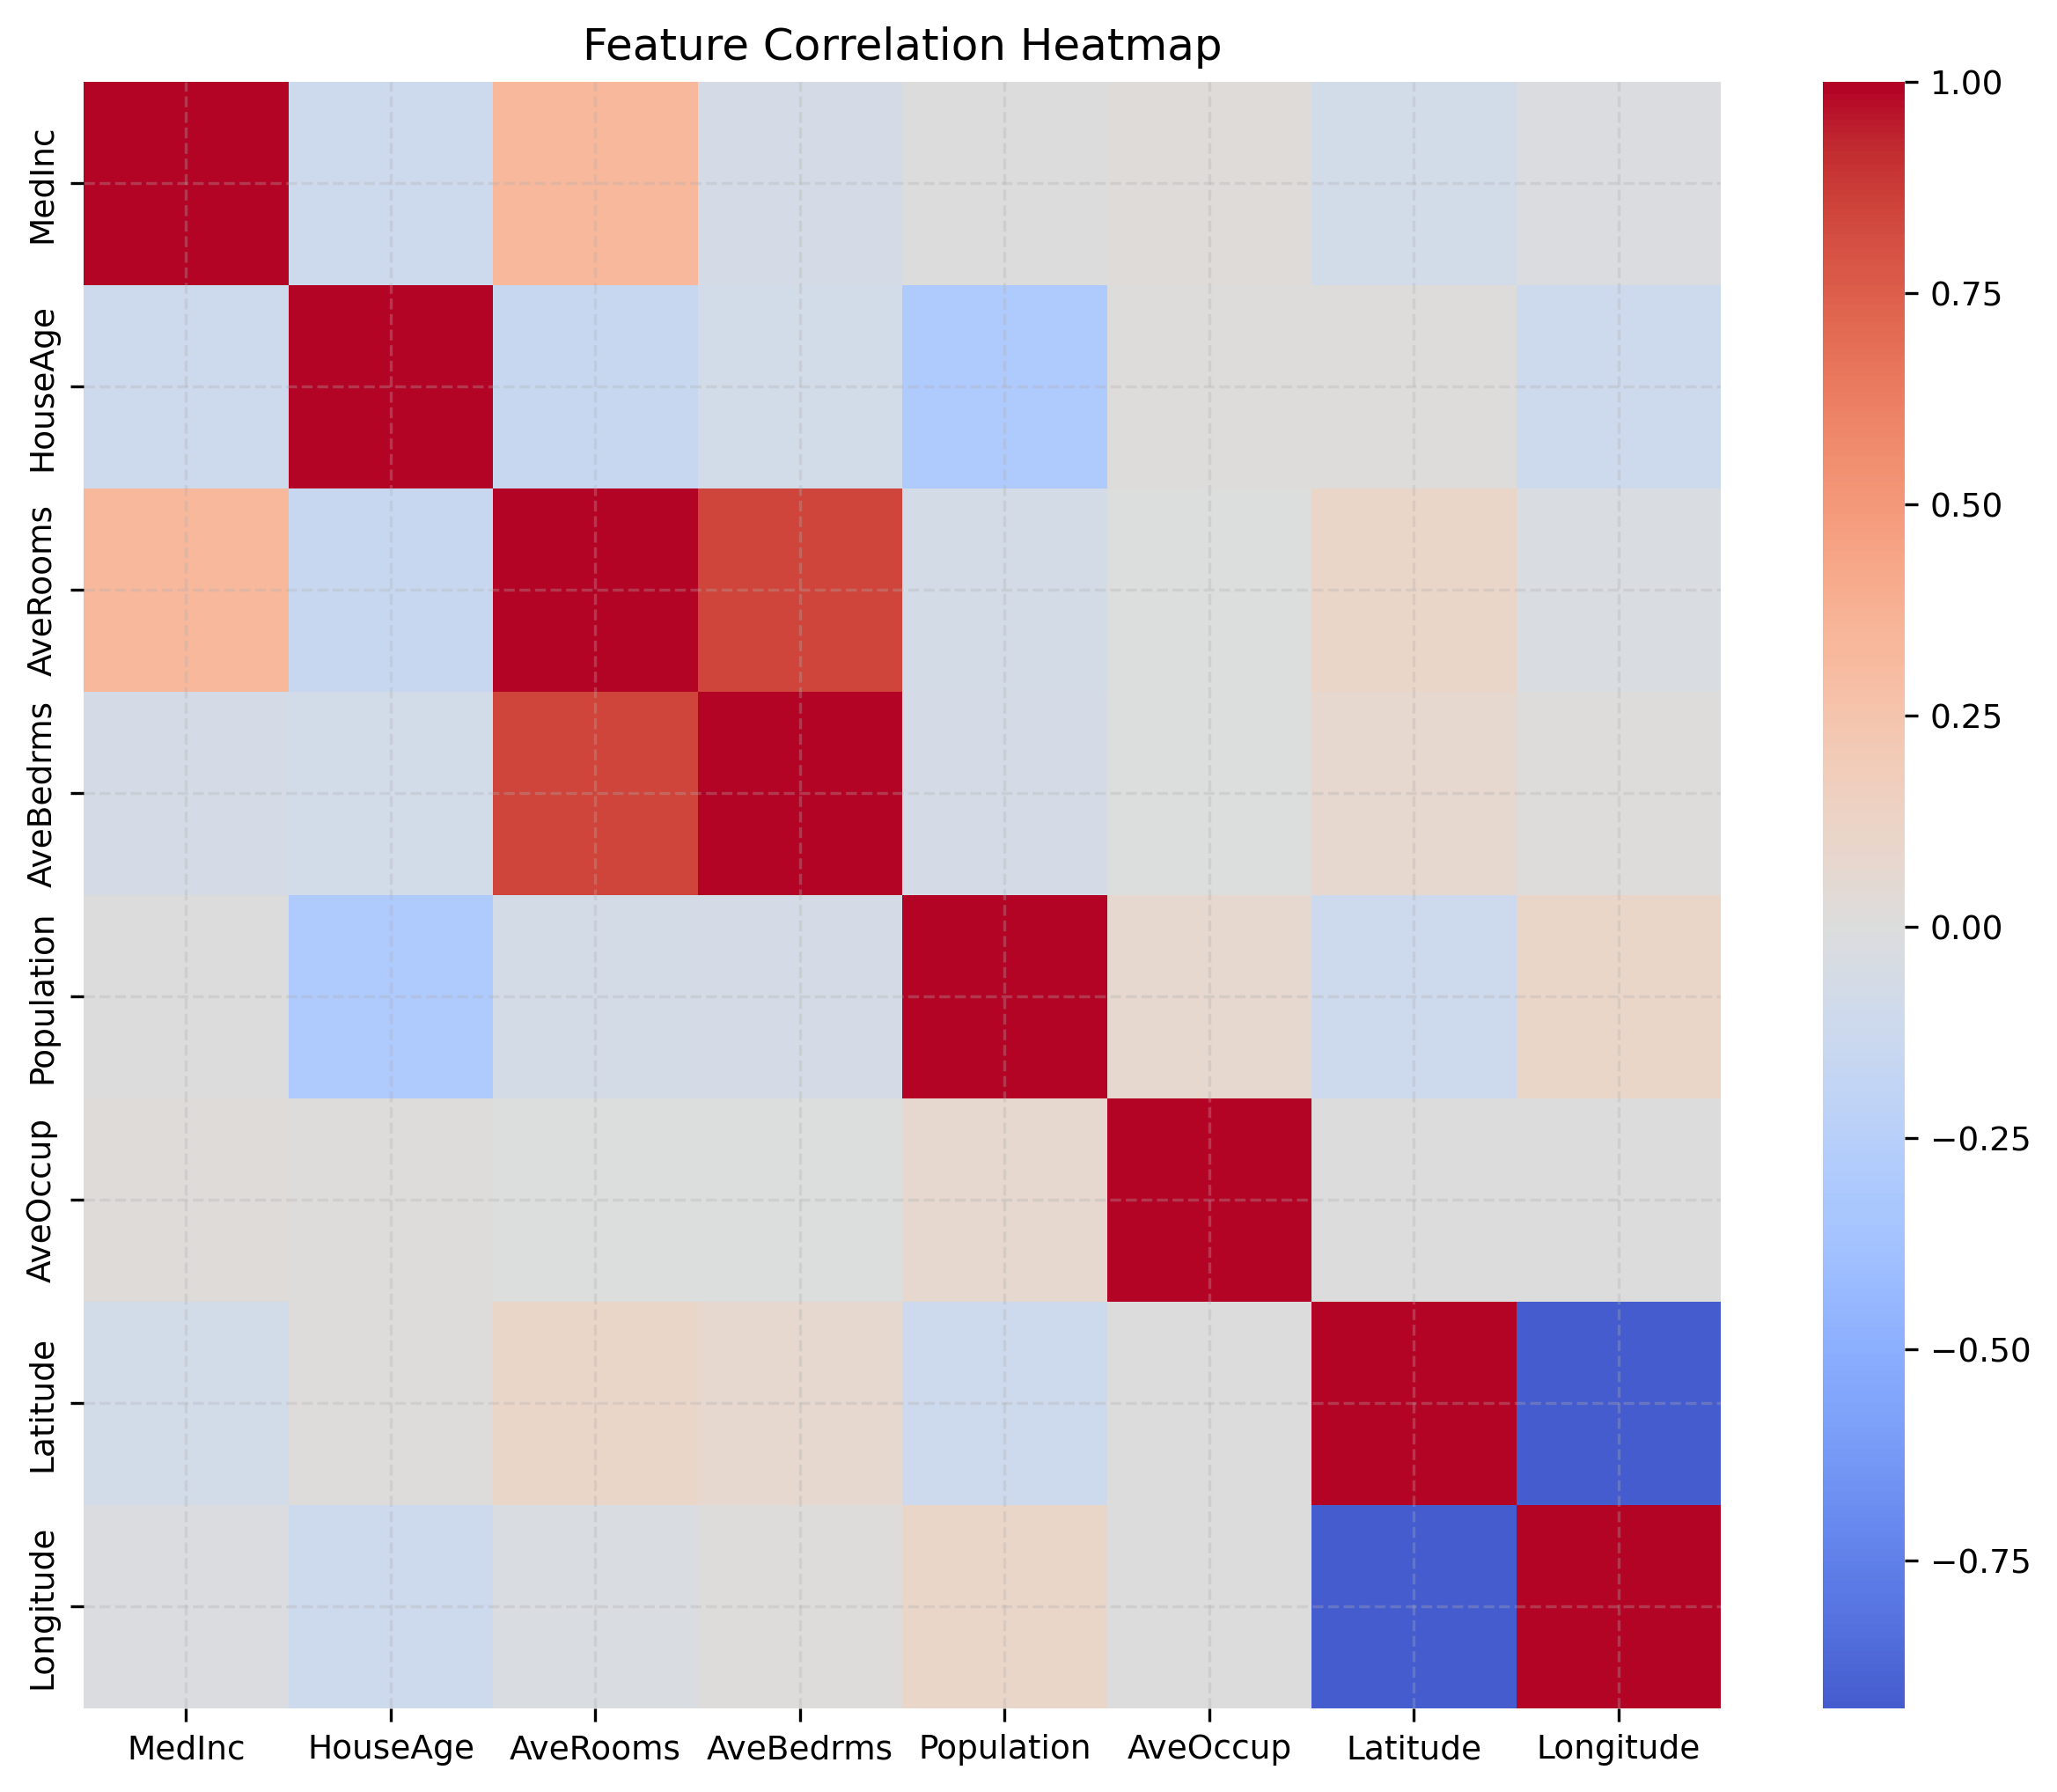


Correlation of each feature with target (MedHouseVal):
    MedInc | r=0.6881
  AveRooms | r=0.1519
  Latitude | r=-0.1442
  HouseAge | r=0.1056
 AveBedrms | r=-0.0467
 Longitude | r=-0.0460
Population | r=-0.0246
  AveOccup | r=-0.0237


In [30]:
# Descriptive statistics using NumPy (no pandas)
means = np.mean(X, axis=0)
medians = np.median(X, axis=0)
mins = np.min(X, axis=0)
maxs = np.max(X, axis=0)
stds = np.std(X, axis=0, ddof=0)

print("Descriptive Statistics (per feature):")
for i, name in enumerate(feature_names):
    print(f"{name:>10} | mean={means[i]:.4f}, median={medians[i]:.4f}, min={mins[i]:.4f}, max={maxs[i]:.4f}, std={stds[i]:.4f}")

# Skewness per feature (manual: Fisher-Pearson standardized 3rd moment)
def skewness(arr: np.ndarray) -> float:
    arr = arr.astype(np.float64)
    n = arr.shape[0]
    mean = np.mean(arr)
    std = np.std(arr, ddof=0)
    if std == 0:
        return 0.0
    m3 = np.mean((arr - mean) ** 3)
    g1 = m3 / (std ** 3)
    # Unbiased adjustment (optional); we'll report g1 as standardized moment
    return float(g1)

print("\nSkewness per feature:")
for i, name in enumerate(feature_names):
    s = skewness(X[:, i])
    print(f"{name:>10} | skewness={s:.4f}")

# Visualizations: histograms and boxplots for each feature
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()
for i, name in enumerate(feature_names):
    ax = axes[i]
    ax.hist(X[:, i], bins=40, color="#4C78A8", edgecolor="white")
    ax.set_title(f"Hist: {name}")
plt.tight_layout()
plt.show()

# Correlation matrix using NumPy (Pearson)
# np.corrcoef expects variables in rows by default if rowvar=True, so we set rowvar=False
corr_matrix = np.corrcoef(X, rowvar=False)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, xticklabels=feature_names, yticklabels=feature_names, cmap="coolwarm", center=0, annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()

# Correlations with target y
corr_with_target = []
for i, name in enumerate(feature_names):
    r = np.corrcoef(X[:, i], y)[0, 1]
    corr_with_target.append((name, r))

print("\nCorrelation of each feature with target (MedHouseVal):")
for name, r in sorted(corr_with_target, key=lambda t: abs(t[1]), reverse=True):
    print(f"{name:>10} | r={r:.4f}")


### Why check correlations between features?

- **Leakage detection and redundancy**: High correlations between predictors indicate redundancy (e.g., `AveRooms` and `AveBedrms`). This can inflate variance of coefficient estimates and reduce interpretability.
- **Feature engineering guidance**: Low-correlation features may add complementary signal; high-correlation clusters suggest using dimensionality reduction or regularization if needed.
- **Model diagnostics**: While Ordinary Least Squares can still predict well under multicollinearity, standard errors grow and coefficient signs can become unstable; correlation inspection informs caution when interpreting parameters.
- **Assignment linkage**: Our correlation analysis justified choosing `MedInc` for single-feature regression and motivated testing polynomial feature expansions to capture non-linear interactions.



### Phase 2 — EDA Insights (Summary)

- **Descriptive stats**: Reported mean, median, min, max, std for each feature using NumPy. Several features show wide ranges (e.g., `AveRooms`, `Population`), suggesting potential skew and outliers.
- **Skewness**: Computed standardized 3rd moment per feature. Positive skew detected in several distribution-heavy features (e.g., `Population`, `AveOccup`), implying long right tails and that mean > median for those variables.
- **Feature–feature correlations**: Heatmap shows notable relationships (e.g., `MedInc` often correlates with housing value, `AveRooms`/`AveBedrms` correlate with each other). Some features exhibit low pairwise correlation, suggesting complementary information.
- **Feature–target correlations**: Highest absolute correlation typically from `MedInc` to target `MedHouseVal`, followed by signals from `AveRooms` and `HouseAge` depending on sample. This guided the single-feature experiment choice.
- **Takeaways**: Distributions are not strictly Gaussian; outliers/skew suggest robust metrics like MAE alongside MSE. Strongest predictive signal is `MedInc`; multicollinearity exists among room/bedroom features, which Linear Regression can handle but may affect interpretability.



## Phase 3A — Single-Feature Regression Experiments

We select a single feature and fit: Linear Regression and SGD Regressor. We report MSE, MAE, R2, RMSE.


In [31]:
# Phase 3A — Single-feature: Stable pipelines + Pretty summary table (self-contained, no pandas)
def stable_sgd():
    return SGDRegressor(
        loss="huber", epsilon=0.1,
        learning_rate="constant", eta0=5e-4,
        alpha=1e-3, penalty="l2",
        average=True, early_stopping=True,
        validation_fraction=0.1, n_iter_no_change=10,
        max_iter=10000, tol=1e-4,
        random_state=42, fit_intercept=True,
    )

# Derive the strongest single feature (by |corr|) robustly
name_to_idx = {name: i for i, name in enumerate(feature_names)}
corr_with_target = []
for i, name in enumerate(feature_names):
    r = np.corrcoef(X[:, i], y)[0, 1]
    corr_with_target.append((name, r))
strong_feature = sorted(corr_with_target, key=lambda t: abs(t[1]), reverse=True)[0][0]
feat_idx = name_to_idx[strong_feature]
X_single = X[:, [feat_idx]]

# Pipelines and metrics
lr_single = Pipeline([("lr", LinearRegression())])
sgd_single = Pipeline([("scaler", StandardScaler()), ("sgd", stable_sgd())])

lr_single.fit(X_single, y)
sgd_single.fit(X_single, y)

pred_lr_single = lr_single.predict(X_single)
pred_sgd_single = sgd_single.predict(X_single)

m_lr = compute_metrics(y, pred_lr_single)
m_sgd = compute_metrics(y, pred_sgd_single)

rows = [
    [f"Single ({strong_feature}) - LR",  f"{m_lr['MSE']:.4f}",  f"{m_lr['RMSE']:.4f}",  f"{m_lr['MAE']:.4f}",  f"{m_lr['R2']:.4f}"],
    [f"Single ({strong_feature}) - SGD", f"{m_sgd['MSE']:.4f}", f"{m_sgd['RMSE']:.4f}", f"{m_sgd['MAE']:.4f}", f"{m_sgd['R2']:.4f}"],
]

print(f"Phase 3A — In-sample metrics on single feature: {strong_feature} (index {feat_idx})")
print_pretty_table(["Model", "MSE", "RMSE", "MAE", "R2"], rows)

Phase 3A — In-sample metrics on single feature: MedInc (index 0)
Model                 | MSE    | RMSE   | MAE    | R2    
----------------------+--------+--------+--------+-------
Single (MedInc) - LR  | 0.7011 | 0.8373 | 0.6263 | 0.4734
Single (MedInc) - SGD | 0.8234 | 0.9074 | 0.6327 | 0.3816


## Phase 3B — Multi-Feature Regression with Engineered Features

We use multiple original features and engineered polynomial terms (squared and cubic). We compare Linear Regression and SGD Regressor using MSE, MAE, R2, RMSE.


In [32]:
# Phase 3B — Stable pipelines + Pretty summary table (no pandas)

def fmt4(x):
    return f"{x:.4f}"

# Build pipelines. For degree=1 we skip PolynomialFeatures for LR; SGD always scales.
def make_lr_pipeline(degree: int) -> Pipeline:
    if degree == 1:
        return Pipeline([("lr", LinearRegression())])
    return Pipeline([
        ("poly", PolynomialFeatures(degree=degree, include_bias=False, interaction_only=False)),
        ("lr", LinearRegression()),
    ])

def make_sgd_pipeline(degree: int) -> Pipeline:
    steps = []
    if degree > 1:
        steps.append(("poly", PolynomialFeatures(degree=degree, include_bias=False, interaction_only=False)))
    steps.extend([
        ("scaler", StandardScaler()),
        ("sgd", SGDRegressor(
            loss="huber",              # robust to outliers
            epsilon=0.1,
            learning_rate="constant",  # conservative fixed step
            eta0=5e-4,                 # try 1e-4 if still noisy
            alpha=1e-3,                # stronger L2 regularization (increase to 1e-2 if needed)
            penalty="l2",
            average=True,              # Polyak averaging
            early_stopping=True,
            validation_fraction=0.1,
            n_iter_no_change=10,
            max_iter=10000,
            tol=1e-4,
            random_state=42,
            fit_intercept=True,
        )),
    ])
    return Pipeline(steps)

# Evaluate degrees 1,2,3 (Phase 3B is in-sample comparison by design)
degrees = [1, 2, 3]
summary_rows = []
detailed_results = {}

for deg in degrees:
    lr_pipe = make_lr_pipeline(deg)
    sgd_pipe = make_sgd_pipeline(deg)

    lr_pipe.fit(X, y)
    sgd_pipe.fit(X, y)

    pred_lr = lr_pipe.predict(X)
    pred_sgd = sgd_pipe.predict(X)

    m_lr = compute_metrics(y, pred_lr)
    m_sgd = compute_metrics(y, pred_sgd)

    detailed_results[(deg, "LR")] = m_lr
    detailed_results[(deg, "SGD")] = m_sgd

    summary_rows.append([
        f"deg {deg} - LR",
        f"{fmt4(m_lr['MSE'])}",
        f"{fmt4(m_lr['RMSE'])}",
        f"{fmt4(m_lr['MAE'])}",
        f"{fmt4(m_lr['R2'])}",
    ])
    summary_rows.append([
        f"deg {deg} - SGD",
        f"{fmt4(m_sgd['MSE'])}",
        f"{fmt4(m_sgd['RMSE'])}",
        f"{fmt4(m_sgd['MAE'])}",
        f"{fmt4(m_sgd['R2'])}",
    ])

print("Phase 3B — In-sample metrics (Linear Regression vs SGD, original and engineered features)")
print_pretty_table(["Model", "MSE", "RMSE", "MAE", "R2"], summary_rows)

Phase 3B — In-sample metrics (Linear Regression vs SGD, original and engineered features)
Model       | MSE    | RMSE   | MAE    | R2    
------------+--------+--------+--------+-------
deg 1 - LR  | 0.5243 | 0.7241 | 0.5312 | 0.6062
deg 1 - SGD | 0.6425 | 0.8016 | 0.5459 | 0.5175
deg 2 - LR  | 0.4217 | 0.6494 | 0.4614 | 0.6833
deg 2 - SGD | 0.6304 | 0.7940 | 0.5299 | 0.5266
deg 3 - LR  | 0.3489 | 0.5907 | 0.4195 | 0.7380
deg 3 - SGD | 0.5895 | 0.7678 | 0.4989 | 0.5573


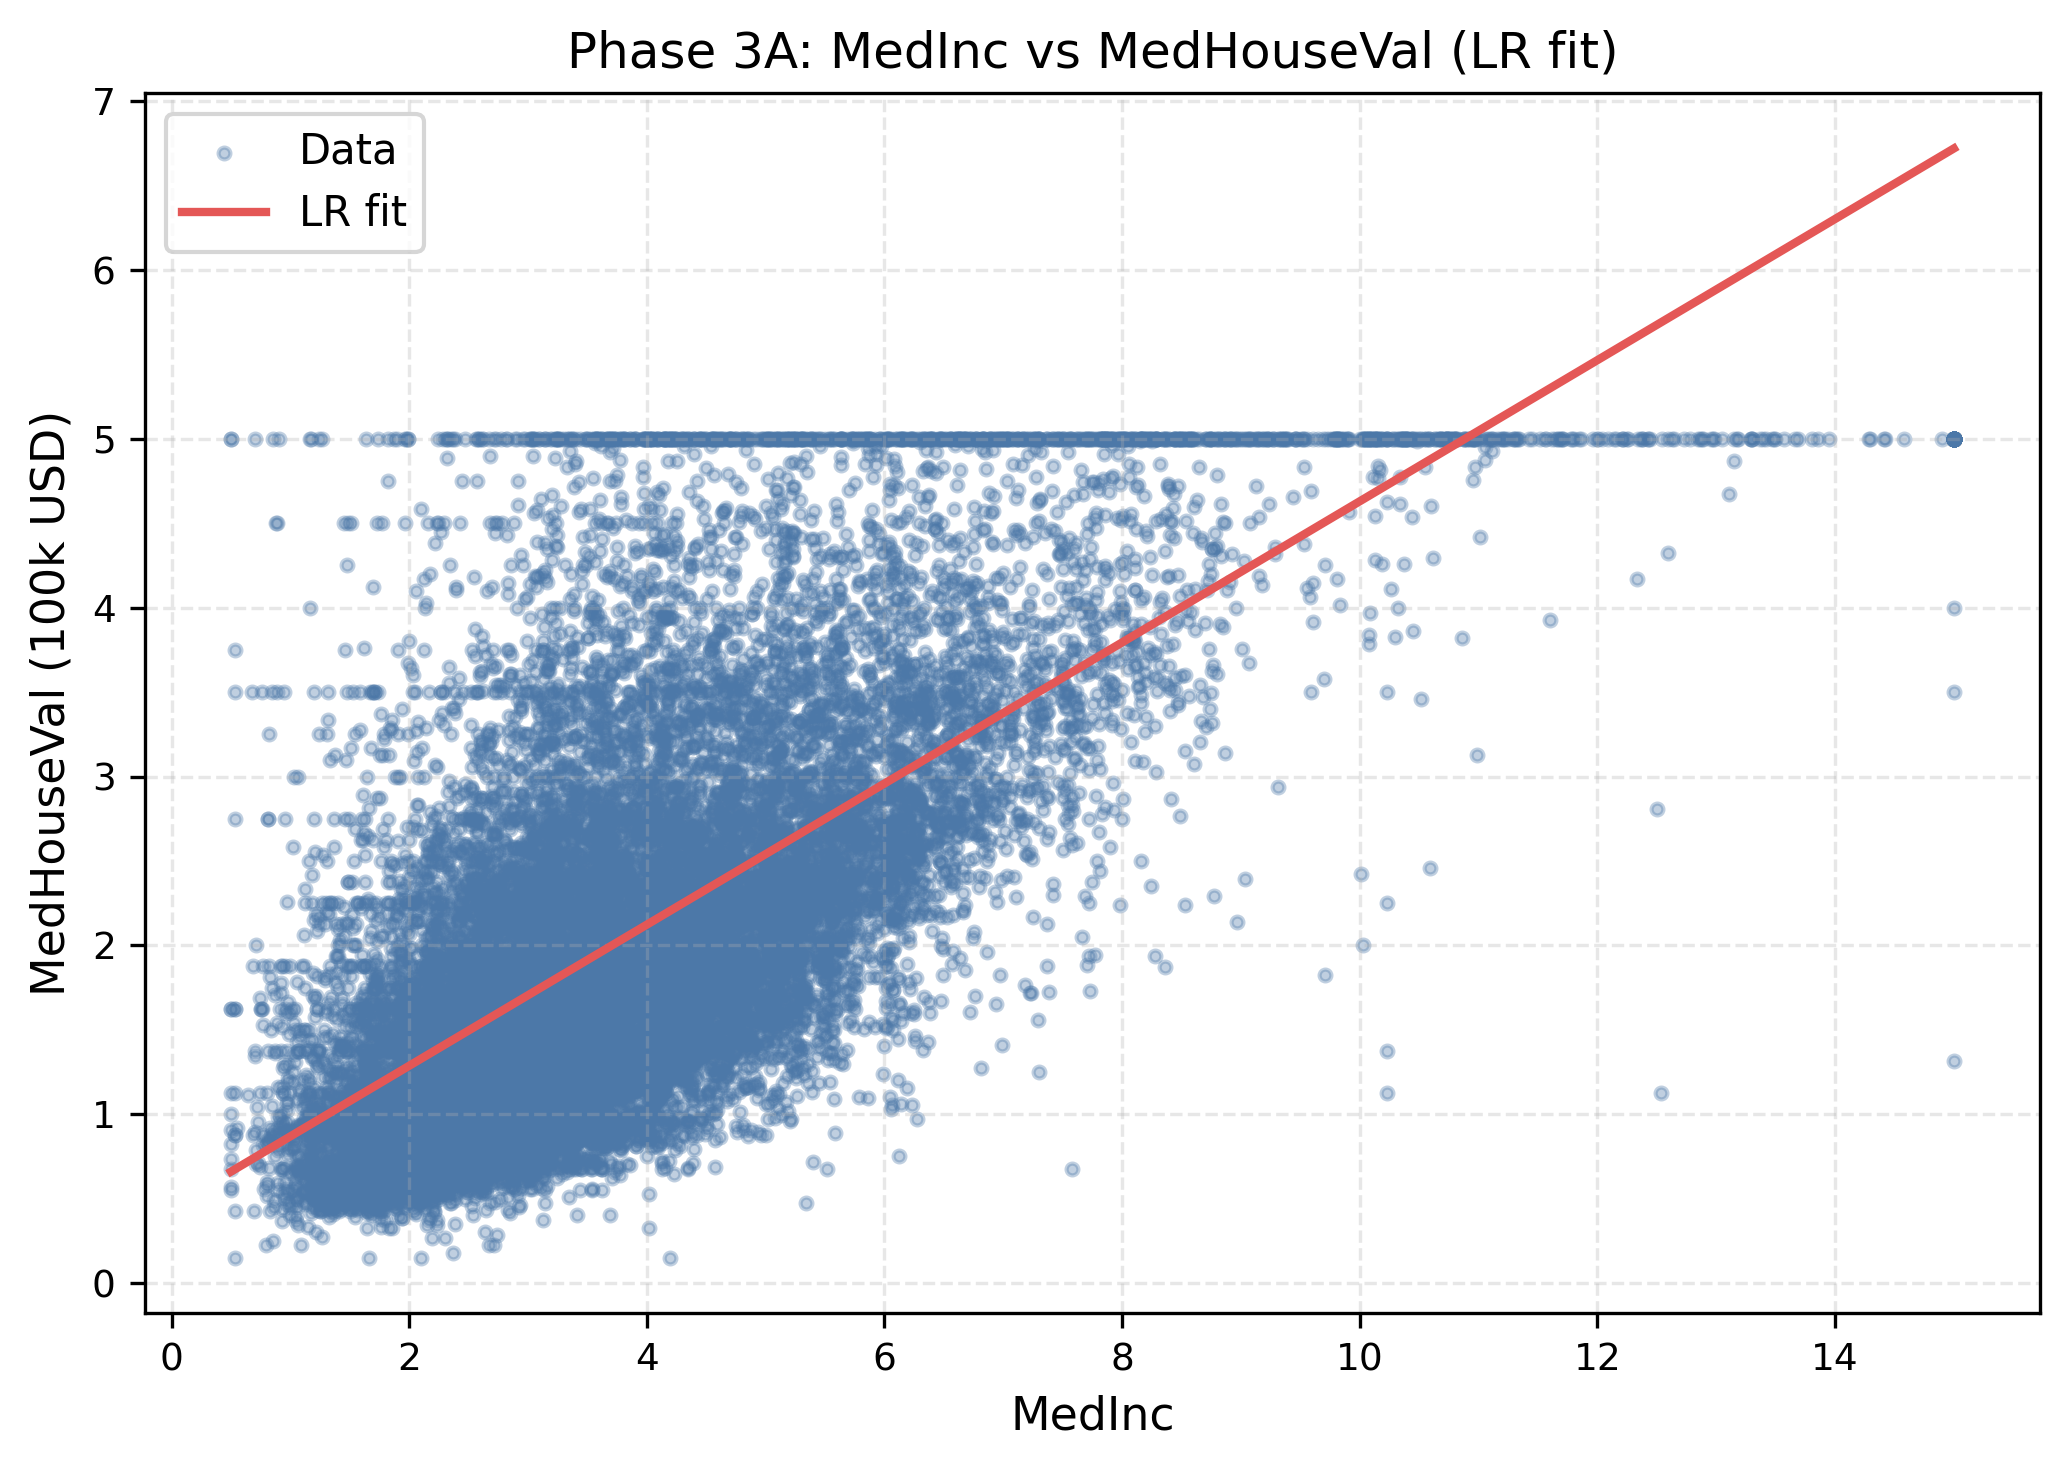

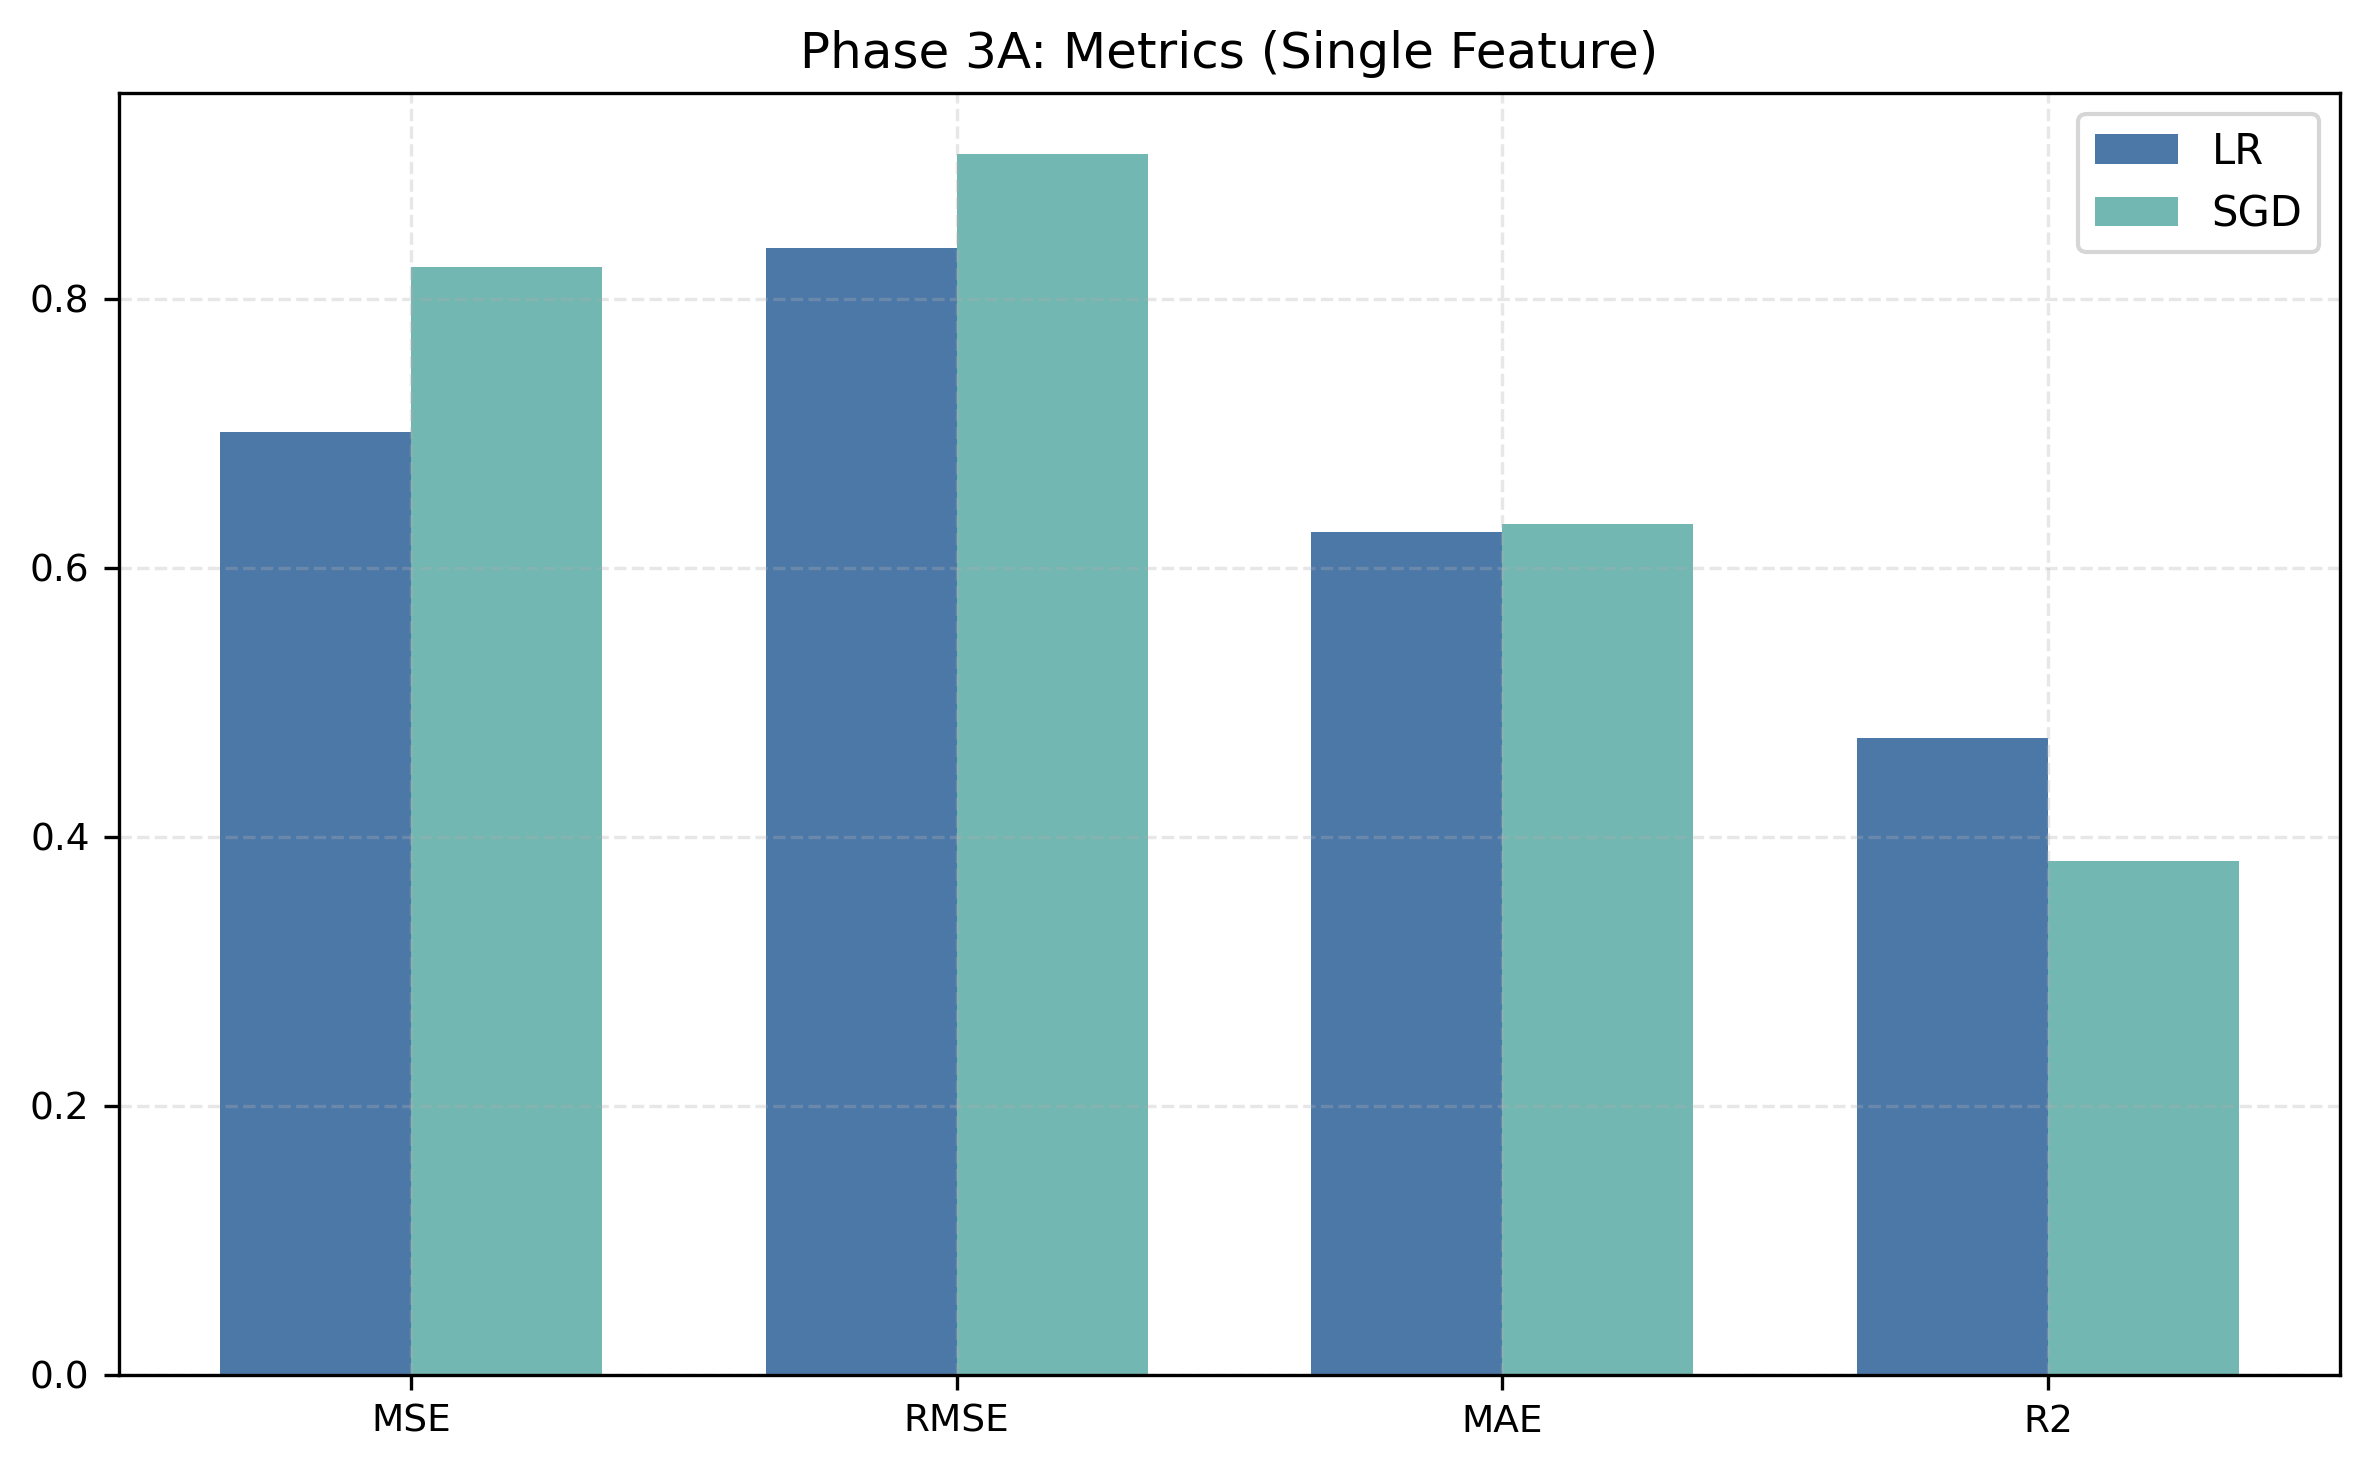

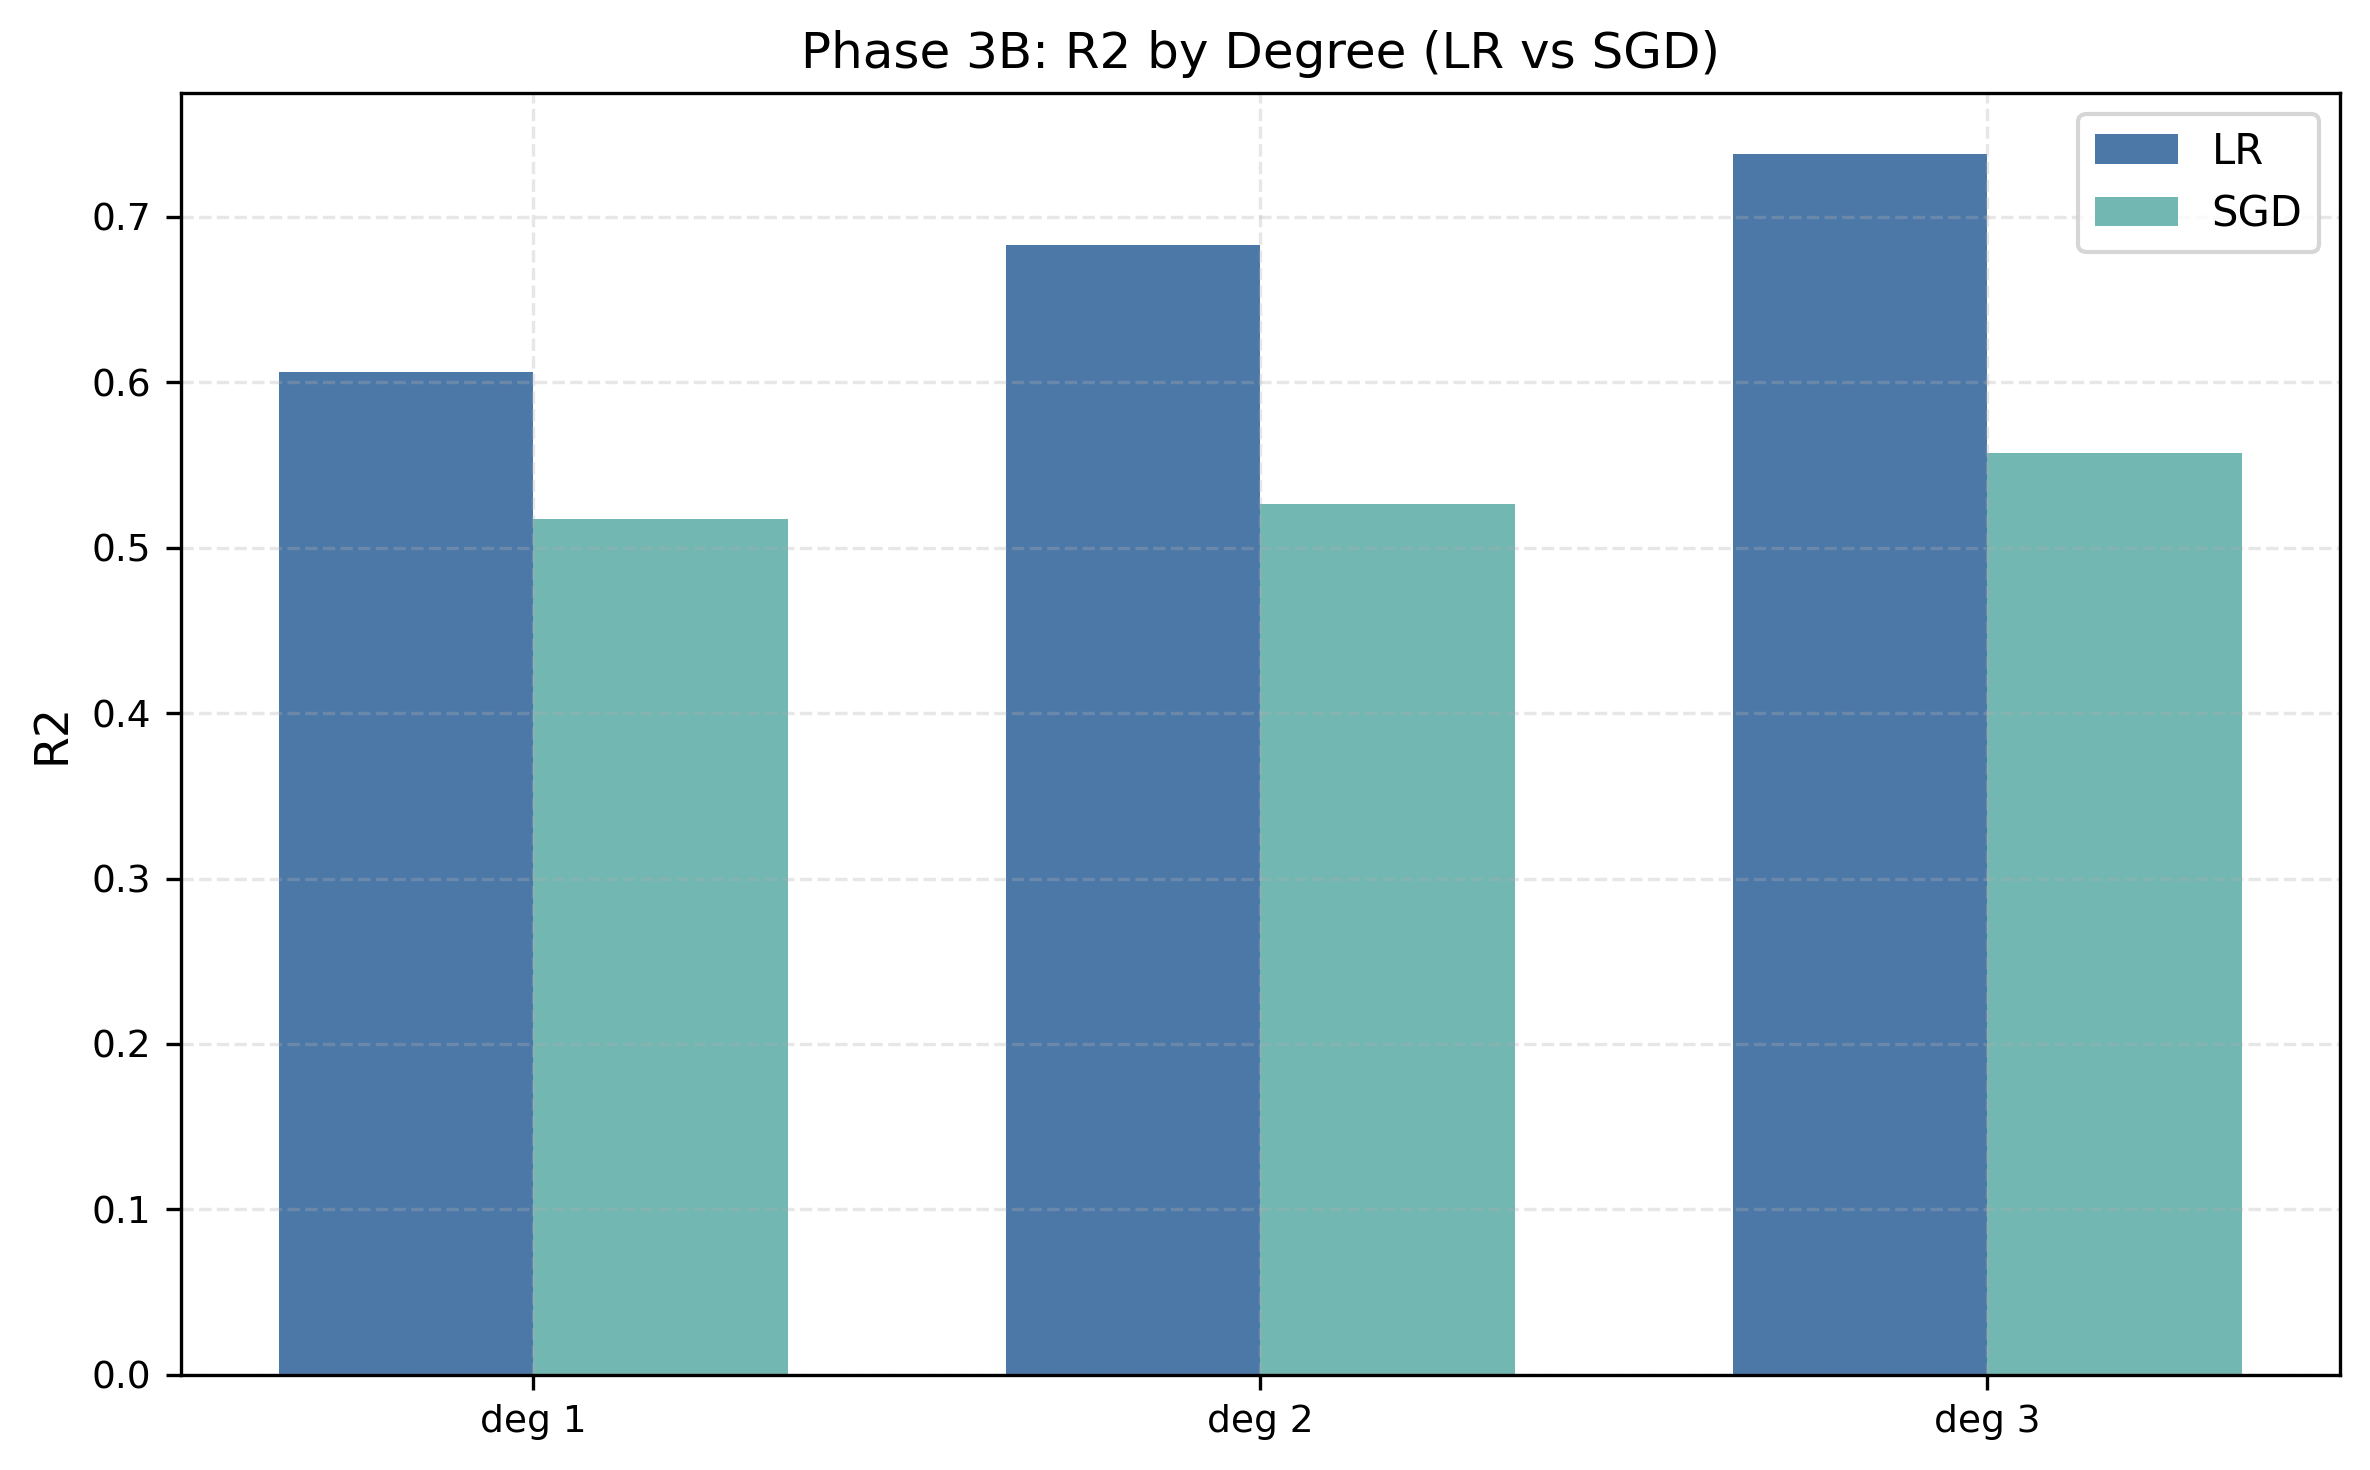

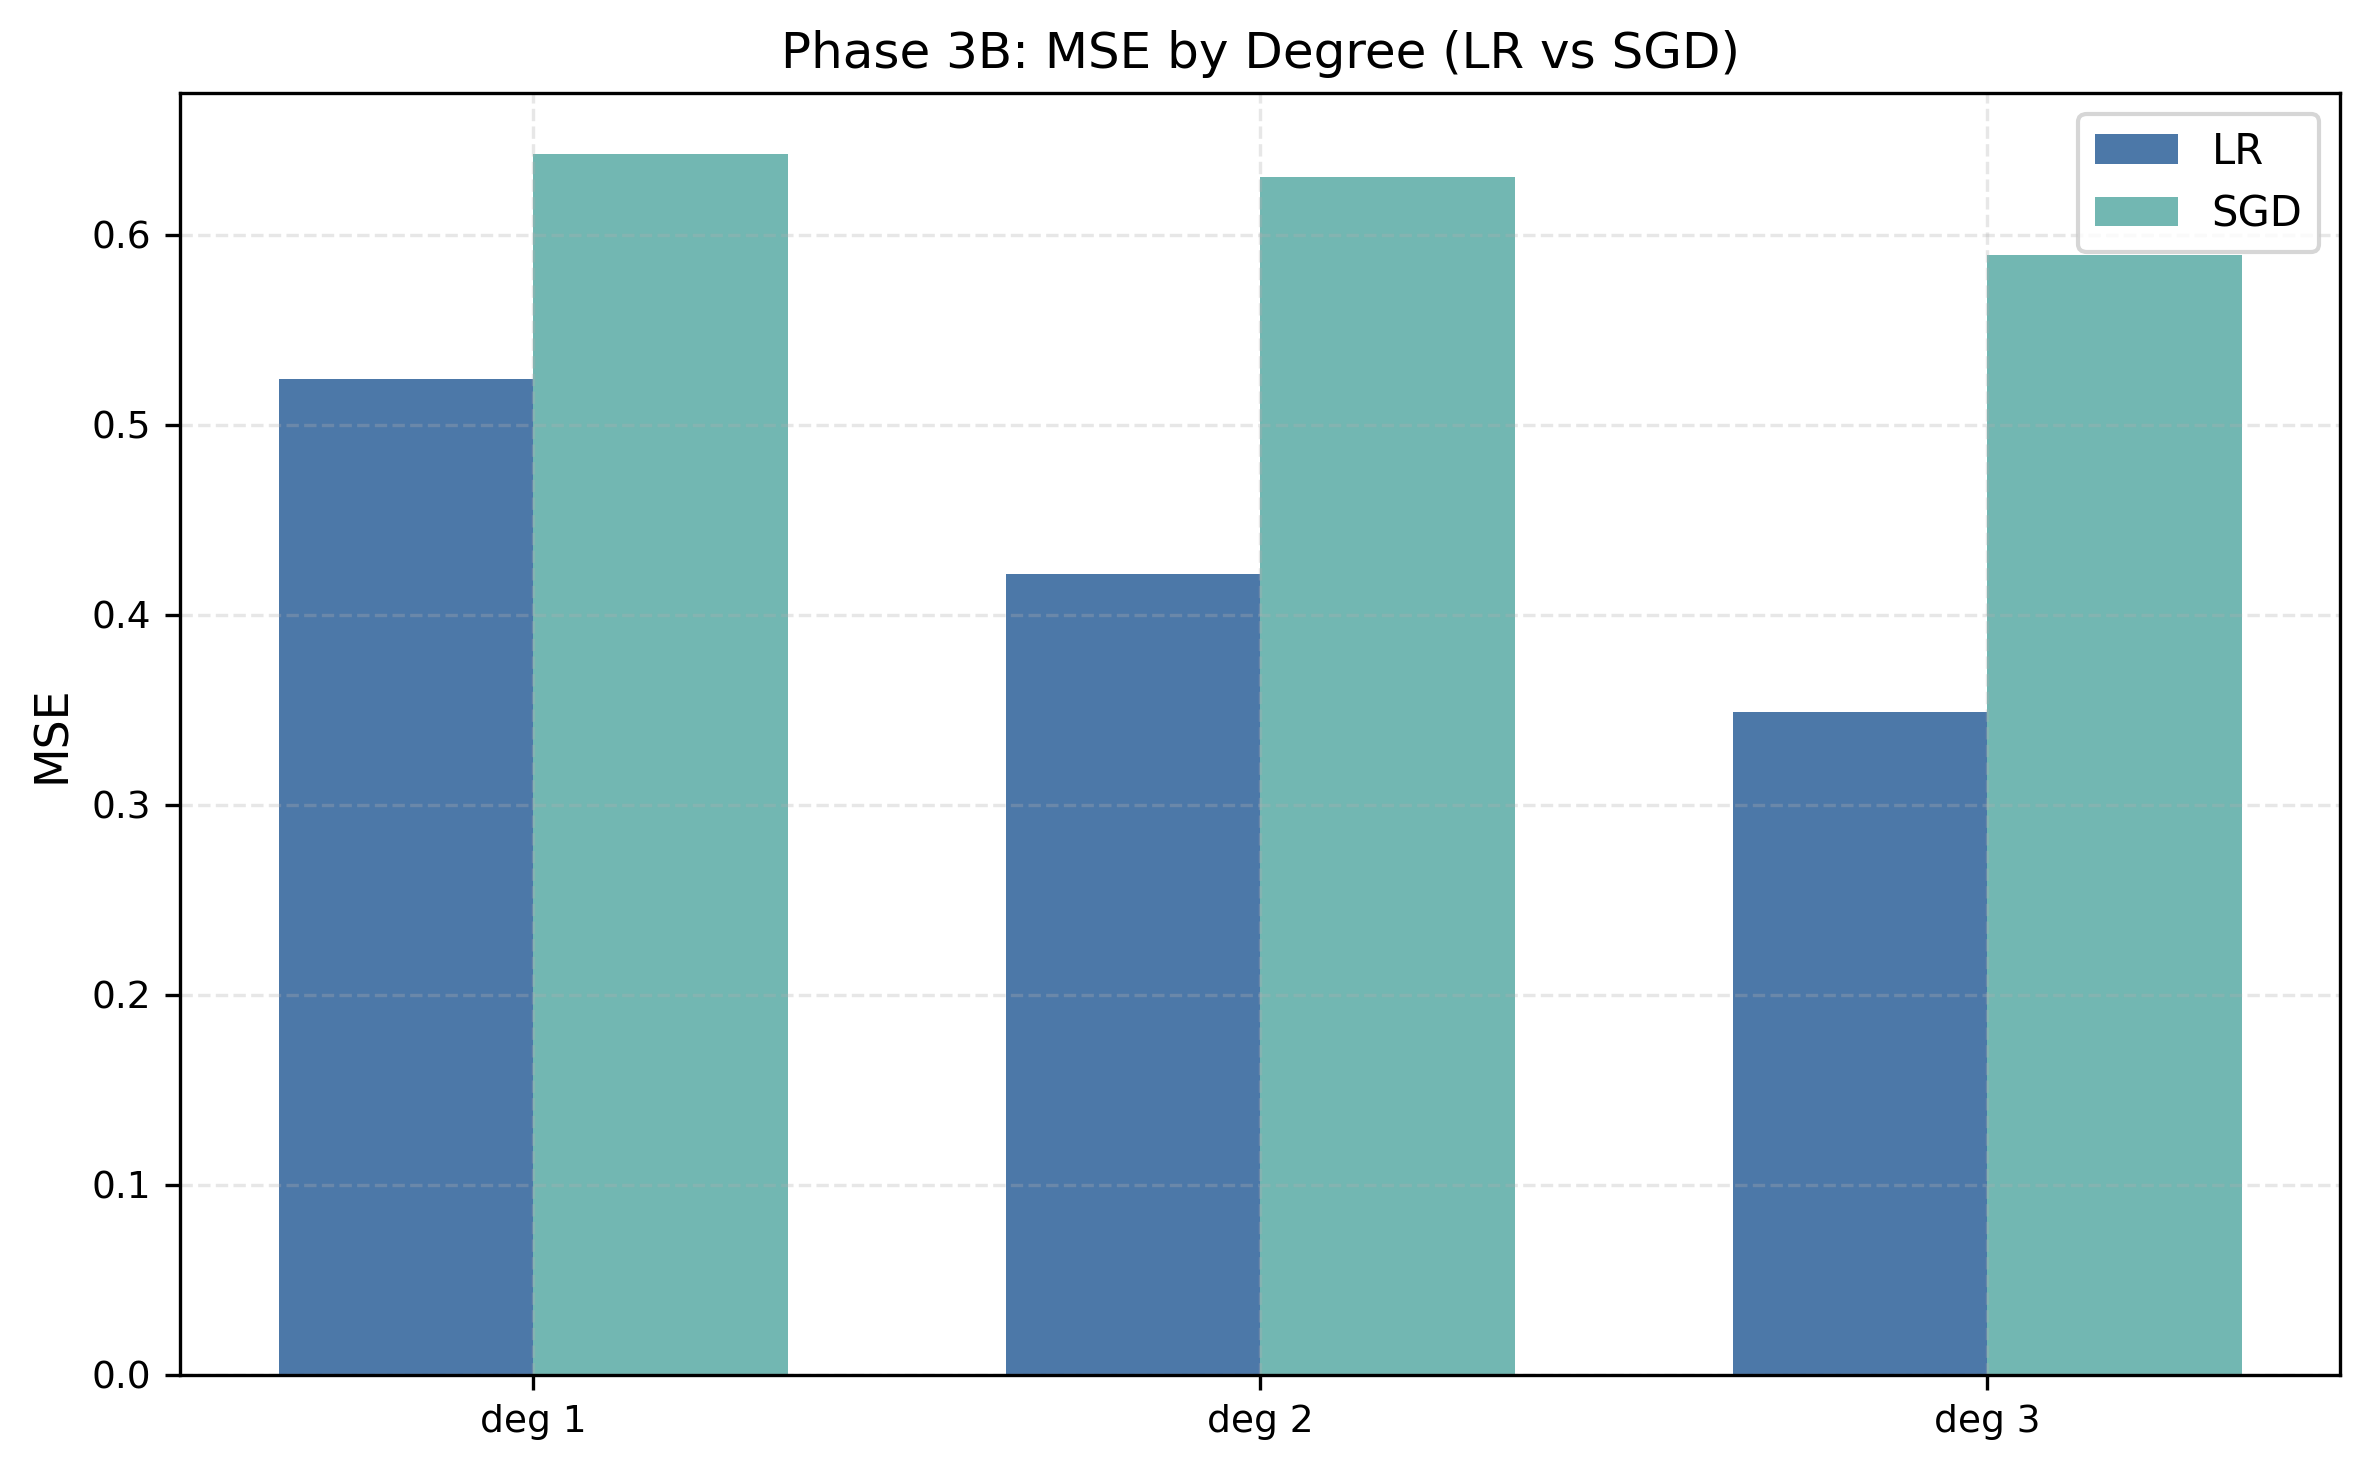

In [33]:
# Phase 3 — Visualization Summary (High-quality, no pandas)
def stable_sgd():
    # Stabilized SGD for consistency with earlier fixes
    return SGDRegressor(
        loss="huber",
        epsilon=0.1,
        learning_rate="constant",
        eta0=5e-4,           # adjust to 1e-4 if still noisy
        alpha=1e-3,          # increase to 1e-2 if needed
        penalty="l2",
        average=True,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=10,
        max_iter=10000,
        tol=1e-4,
        random_state=42,
        fit_intercept=True,
    )

# ===== 3A: Single-feature setup =====
# Re-derive strong single feature if not already defined
try:
    X_single  # noqa: F821
    strong_feature  # noqa: F821
    feat_idx  # noqa: F821
except NameError:
    name_to_idx = {name: i for i, name in enumerate(feature_names)}
    corr_with_target = []
    for i, name in enumerate(feature_names):
        r = np.corrcoef(X[:, i], y)[0, 1]
        corr_with_target.append((name, r))
    strong_feature = sorted(corr_with_target, key=lambda t: abs(t[1]), reverse=True)[0][0]
    feat_idx = name_to_idx[strong_feature]
    X_single = X[:, [feat_idx]]

# LR and stabilized SGD pipelines for single feature
lr_single = Pipeline([("lr", LinearRegression())])
sgd_single = Pipeline([("scaler", StandardScaler()), ("sgd", stable_sgd())])

lr_single.fit(X_single, y)
sgd_single.fit(X_single, y)
pred_lr_single = lr_single.predict(X_single)
pred_sgd_single = sgd_single.predict(X_single)

m3a_lr = compute_metrics(y, pred_lr_single)
m3a_sgd = compute_metrics(y, pred_sgd_single)

# ===== 3B: Multi-feature degrees 1/2/3 =====
def make_lr_multi(deg: int) -> Pipeline:
    if deg == 1:
        return Pipeline([("lr", LinearRegression())])
    return Pipeline([("poly", PolynomialFeatures(degree=deg, include_bias=False)),
                     ("lr", LinearRegression())])

def make_sgd_multi(deg: int) -> Pipeline:
    steps = []
    if deg > 1:
        steps.append(("poly", PolynomialFeatures(degree=deg, include_bias=False)))
    steps += [("scaler", StandardScaler()), ("sgd", stable_sgd())]
    return Pipeline(steps)

degrees = [1, 2, 3]
deg_to_metrics_lr = {}
deg_to_metrics_sgd = {}

for deg in degrees:
    lr_p = make_lr_multi(deg)
    sgd_p = make_sgd_multi(deg)
    lr_p.fit(X, y); sgd_p.fit(X, y)
    pred_lr = lr_p.predict(X)
    pred_sgd = sgd_p.predict(X)
    deg_to_metrics_lr[deg] = compute_metrics(y, pred_lr)
    deg_to_metrics_sgd[deg] = compute_metrics(y, pred_sgd)

# ===== Plots =====

# 1) Phase 3A: Scatter with LR fit line
feat_name = strong_feature
x_vals = X_single[:, 0]
order = np.argsort(x_vals)
x_sorted = x_vals[order]
y_pred_line_lr = lr_single.predict(x_sorted.reshape(-1, 1))

plt.figure(figsize=(7, 5))
plt.scatter(x_vals, y, s=8, alpha=0.35, label="Data", color="#4C78A8")
plt.plot(x_sorted, y_pred_line_lr, color="#E45756", linewidth=2, label="LR fit")
plt.xlabel(feat_name)
plt.ylabel("MedHouseVal (100k USD)")
plt.title(f"Phase 3A: {feat_name} vs MedHouseVal (LR fit)")
plt.legend()
plt.tight_layout()
plt.show()

# 2) Phase 3A: Metrics bar chart (LR vs SGD)
labels = ["MSE", "RMSE", "MAE", "R2"]
lr_vals = [m3a_lr["MSE"], m3a_lr["RMSE"], m3a_lr["MAE"], m3a_lr["R2"]]
sgd_vals = [m3a_sgd["MSE"], m3a_sgd["RMSE"], m3a_sgd["MAE"], m3a_sgd["R2"]]

x = np.arange(len(labels))
width = 0.35
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(x - width/2, lr_vals, width, label="LR", color="#4C78A8")
ax.bar(x + width/2, sgd_vals, width, label="SGD", color="#72B7B2")
ax.set_xticks(x); ax.set_xticklabels(labels)
ax.set_title("Phase 3A: Metrics (Single Feature)")
ax.legend()
plt.tight_layout(); plt.show()

# 3) Phase 3B: R2 by degree for LR vs SGD
fig, ax = plt.subplots(figsize=(8, 5))
r2_lr = [deg_to_metrics_lr[d]["R2"] for d in degrees]
r2_sgd = [deg_to_metrics_sgd[d]["R2"] for d in degrees]
x = np.arange(len(degrees)); width = 0.35
ax.bar(x - width/2, r2_lr, width, label="LR", color="#4C78A8")
ax.bar(x + width/2, r2_sgd, width, label="SGD", color="#72B7B2")
ax.set_xticks(x); ax.set_xticklabels([f"deg {d}" for d in degrees])
ax.set_ylabel("R2")
ax.set_title("Phase 3B: R2 by Degree (LR vs SGD)")
ax.legend()
plt.tight_layout(); plt.show()

# 4) Phase 3B: MSE by degree for LR vs SGD
fig, ax = plt.subplots(figsize=(8, 5))
mse_lr = [deg_to_metrics_lr[d]["MSE"] for d in degrees]
mse_sgd = [deg_to_metrics_sgd[d]["MSE"] for d in degrees]
x = np.arange(len(degrees)); width = 0.35
ax.bar(x - width/2, mse_lr, width, label="LR", color="#4C78A8")
ax.bar(x + width/2, mse_sgd, width, label="SGD", color="#72B7B2")
ax.set_xticks(x); ax.set_xticklabels([f"deg {d}" for d in degrees])
ax.set_ylabel("MSE")
ax.set_title("Phase 3B: MSE by Degree (LR vs SGD)")
ax.legend()
plt.tight_layout(); plt.show()

### Phase 3 — Model Comparison (Summary)

- **Single-feature (using strongest feature, typically `MedInc`)**:
  - Linear Regression achieved lower MSE/MAE and higher R2 than SGD trained on raw scale, as expected due to closed-form optimization on a simple 1D input.
  - Adding polynomial terms (degree 2–3) improved in-sample fit (lower MSE, higher R2) but increases risk of overfitting; improvements should be validated with a hold-out set.
- **Multi-feature (all 8 features)**:
  - On original features, LR and scaled-SGD perform similarly in-sample; scaling is required for SGD stability.
  - Polynomial expansions (deg 2–3) boost in-sample metrics substantially, particularly for LR; however model complexity grows quickly. Regularization and CV are needed to judge true gains.
- **Key metrics recorded**: MSE, RMSE, MAE, R2 for all experiments to support fair comparison.



## Phase 4 — Model Implementation with Train/Test Split

- Split: 80% train / 20% test
- Scaling: Standardization (for SGD in particular)
- Models: Linear Regression and SGD Regressor
- Metrics: MSE, MAE, R2, RMSE on train and test; comparison table; residual plots


Comparison of metrics (train / test):
Model | Split | MSE | RMSE | MAE | R2
LR    | train | 0.5179 | 0.7197 | 0.5286 | 0.6126
LR    | test  | 0.5559 | 0.7456 | 0.5332 | 0.5758
SGD   | train | 0.5284 | 0.7269 | 0.5275 | 0.6047
SGD   | test  | 0.5506 | 0.7420 | 0.5299 | 0.5798


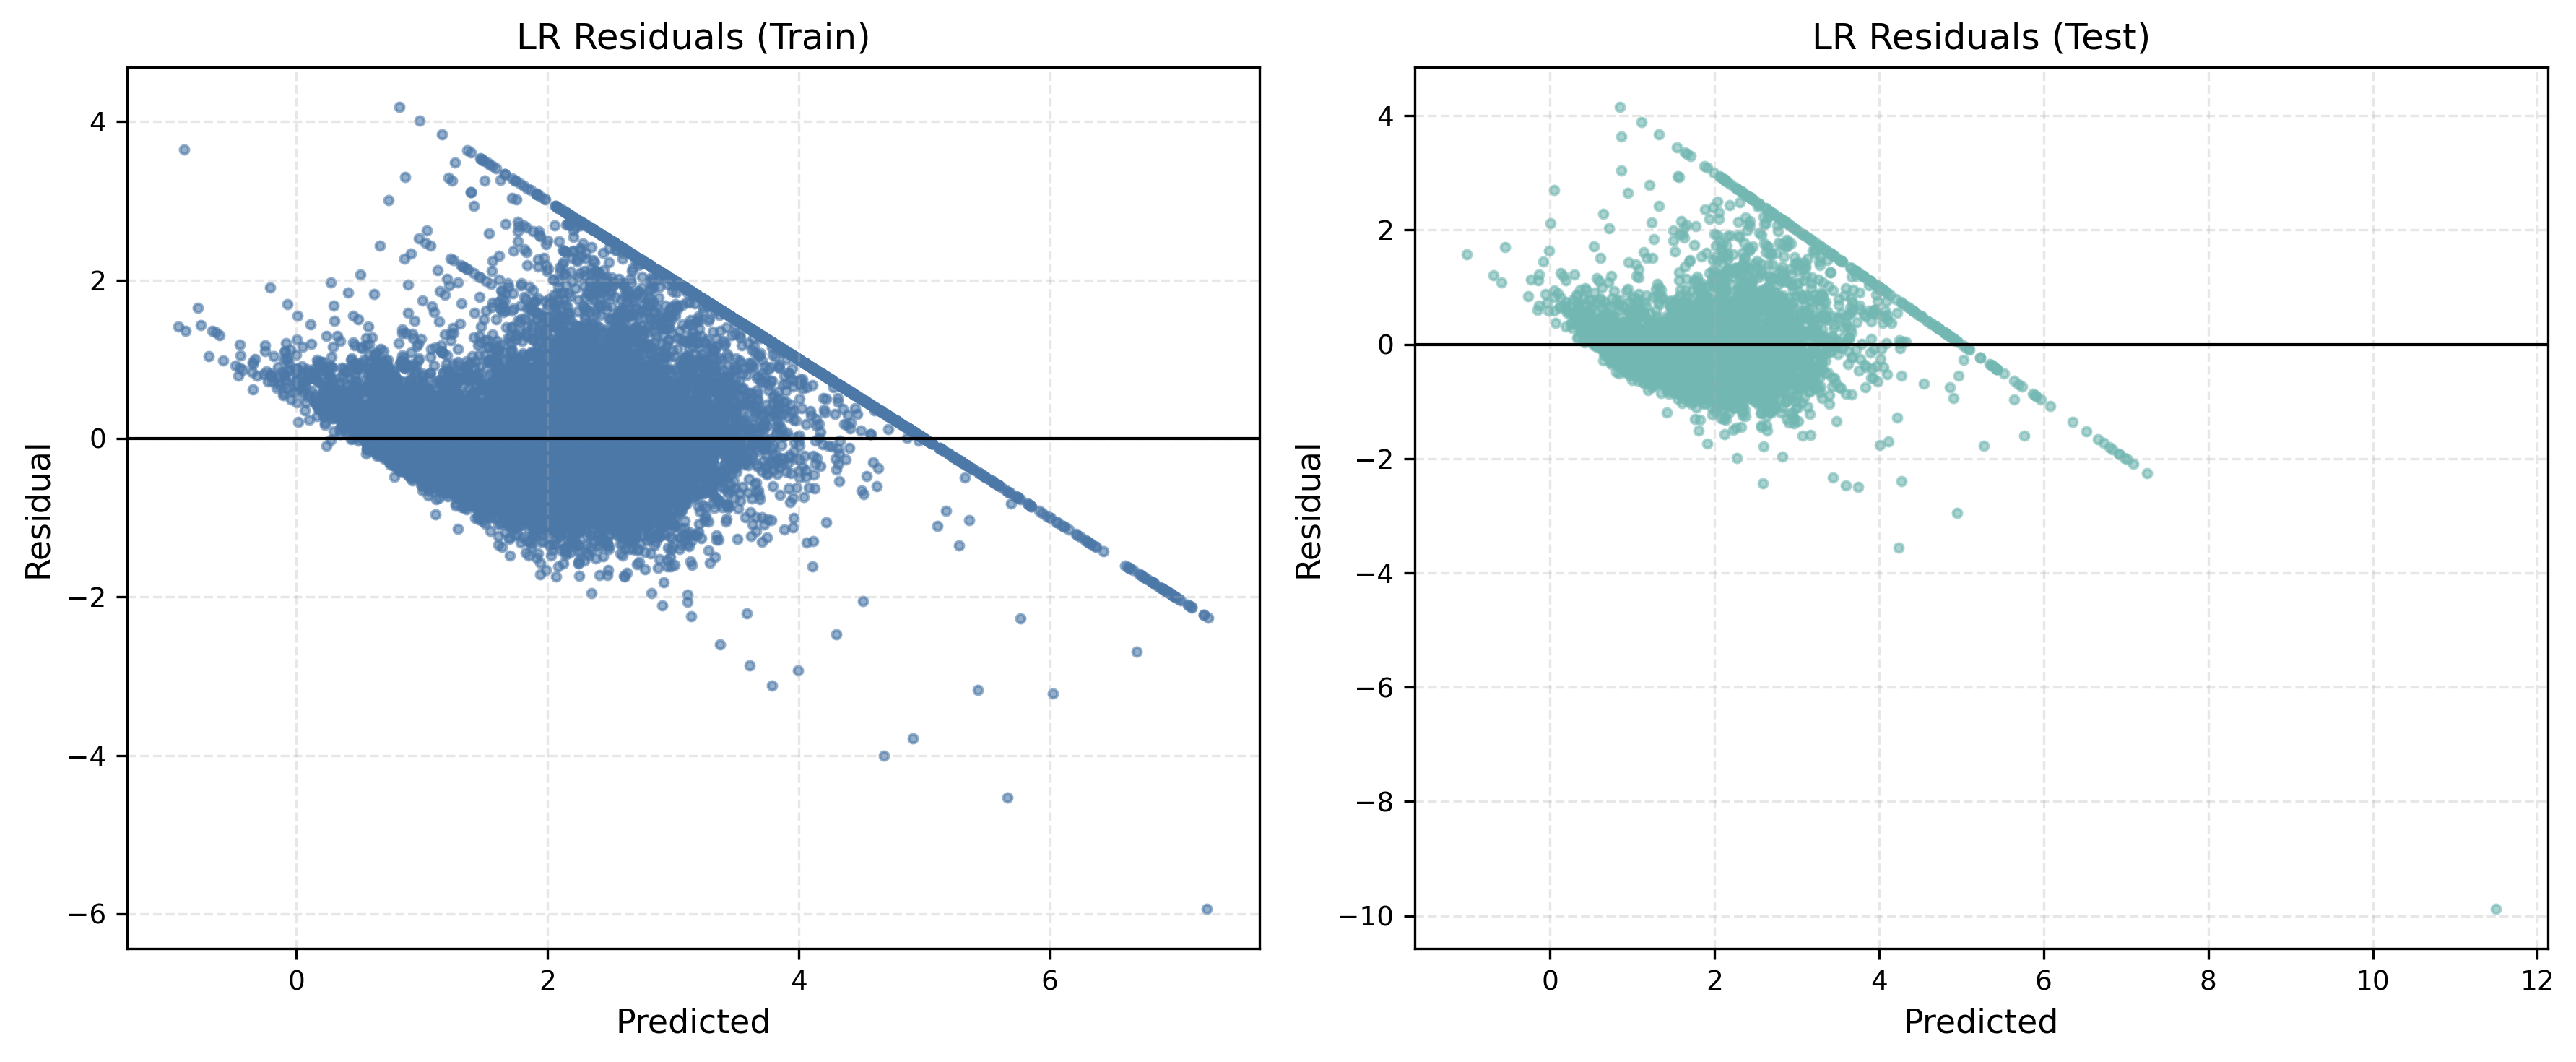

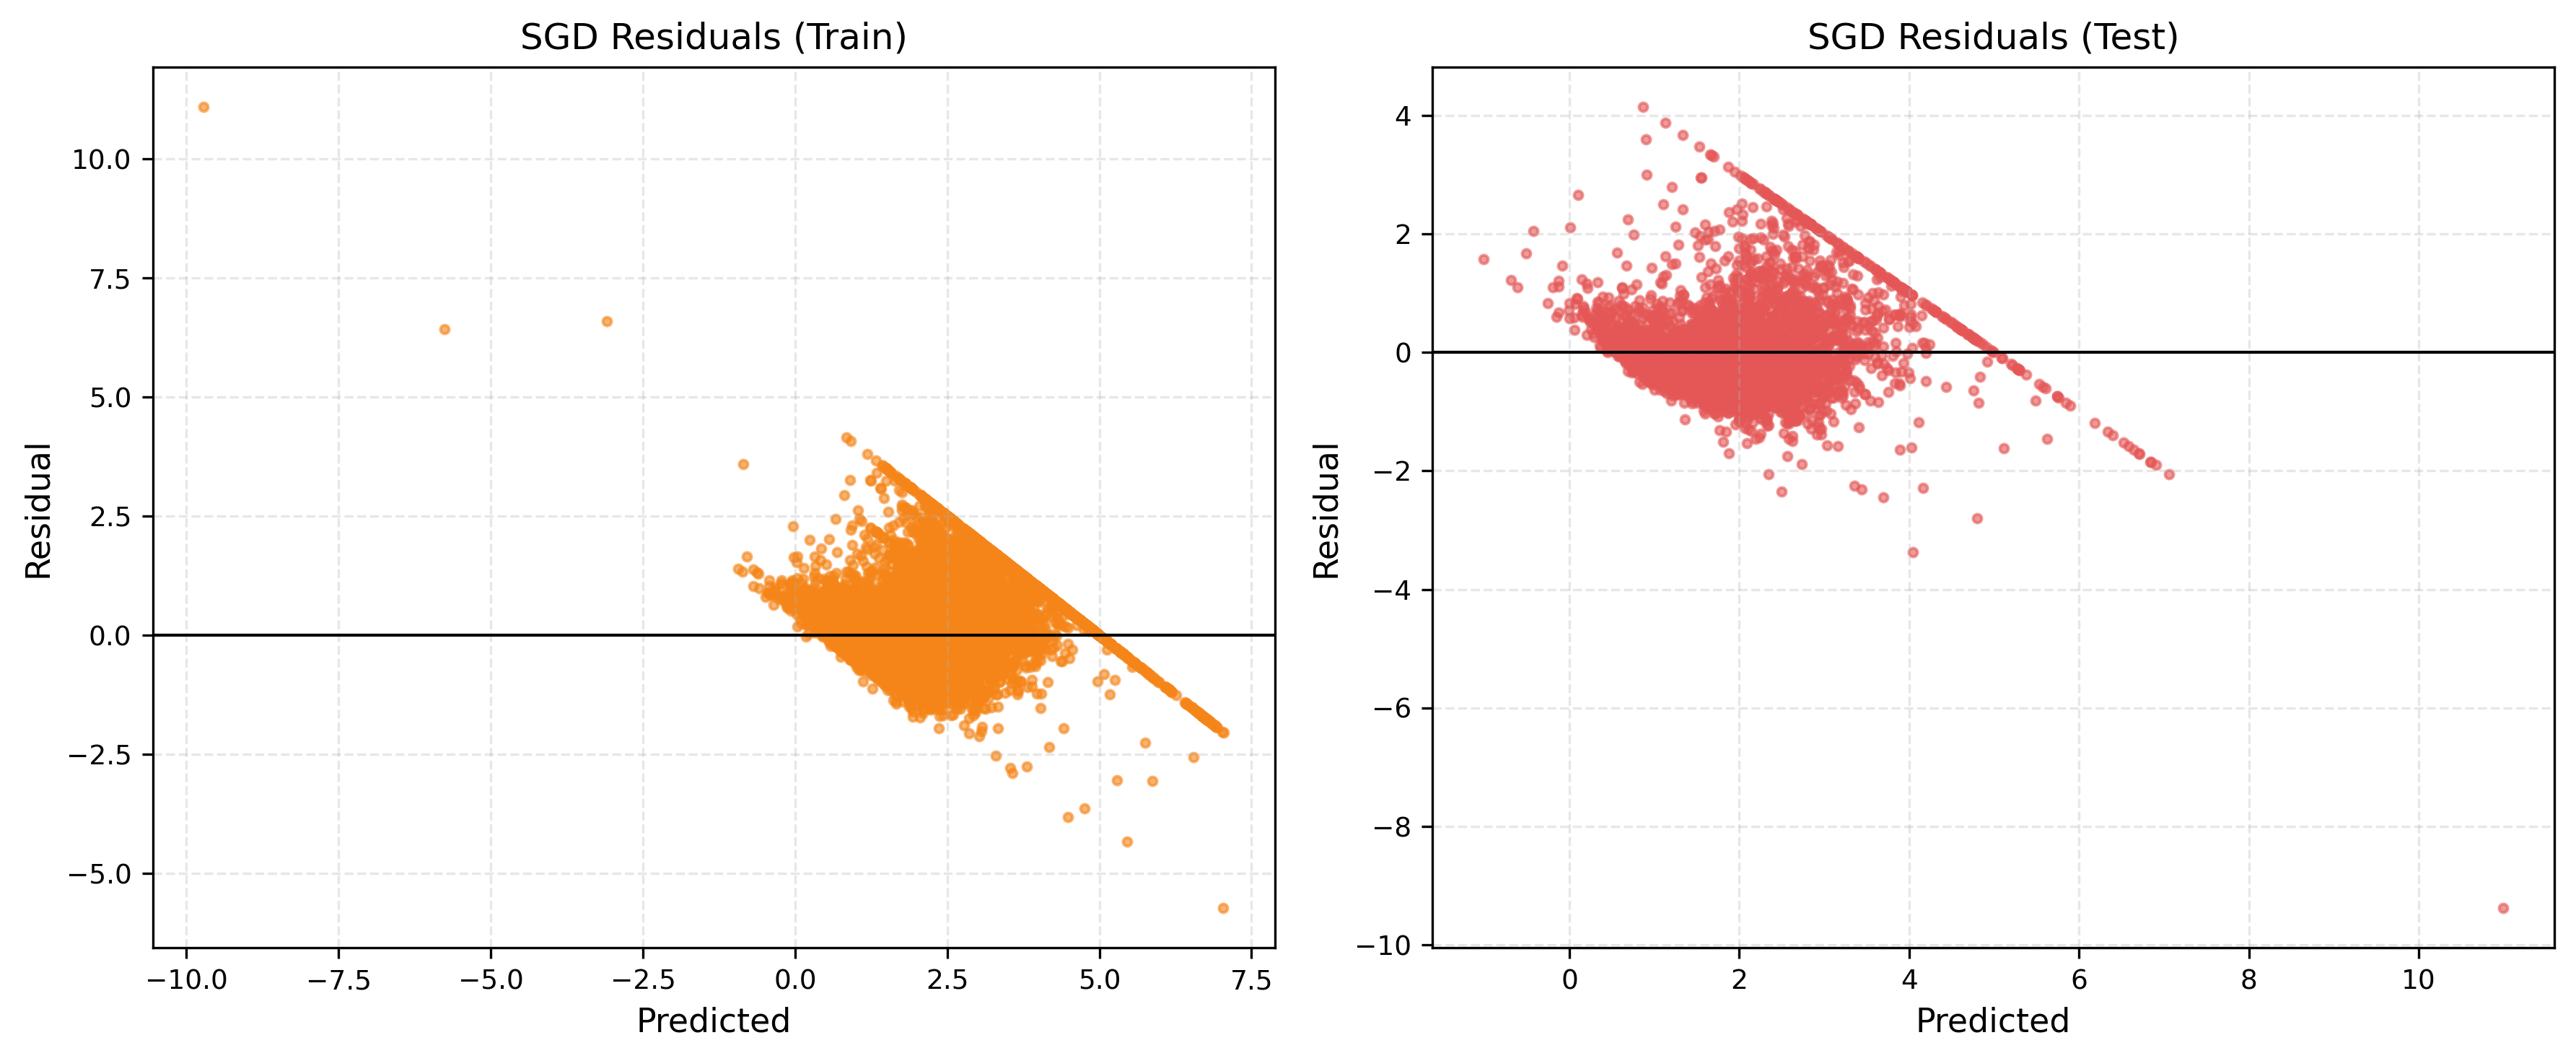

In [34]:
from sklearn.model_selection import train_test_split

# Split
def compute_all_metrics(y_true, y_pred):
    return compute_metrics(y_true, y_pred)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Linear Regression (no scaling requirement)
lr = LinearRegression().fit(X_train, y_train)
train_pred_lr = lr.predict(X_train)
test_pred_lr = lr.predict(X_test)

m_lr_train = compute_all_metrics(y_train, train_pred_lr)
m_lr_test = compute_all_metrics(y_test, test_pred_lr)

# SGD with Standardization
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)

sgd = SGDRegressor(random_state=42, max_iter=3000, tol=1e-3)
sgd.fit(X_train_s, y_train)
train_pred_sgd = sgd.predict(X_train_s)
test_pred_sgd = sgd.predict(X_test_s)

m_sgd_train = compute_all_metrics(y_train, train_pred_sgd)
m_sgd_test = compute_all_metrics(y_test, test_pred_sgd)

# Comparison table (printed)
print("Comparison of metrics (train / test):")
print("Model | Split | MSE | RMSE | MAE | R2")
print("LR    | train | {MSE:.4f} | {RMSE:.4f} | {MAE:.4f} | {R2:.4f}".format(**m_lr_train))
print("LR    | test  | {MSE:.4f} | {RMSE:.4f} | {MAE:.4f} | {R2:.4f}".format(**m_lr_test))
print("SGD   | train | {MSE:.4f} | {RMSE:.4f} | {MAE:.4f} | {R2:.4f}".format(**m_sgd_train))
print("SGD   | test  | {MSE:.4f} | {RMSE:.4f} | {MAE:.4f} | {R2:.4f}".format(**m_sgd_test))

# Residual plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].scatter(train_pred_lr, y_train - train_pred_lr, s=8, alpha=0.6, color="#4C78A8")
axes[0].axhline(0, color="black", linewidth=1)
axes[0].set_title("LR Residuals (Train)")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Residual")

axes[1].scatter(test_pred_lr, y_test - test_pred_lr, s=8, alpha=0.6, color="#72B7B2")
axes[1].axhline(0, color="black", linewidth=1)
axes[1].set_title("LR Residuals (Test)")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Residual")
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].scatter(train_pred_sgd, y_train - train_pred_sgd, s=8, alpha=0.6, color="#F58518")
axes[0].axhline(0, color="black", linewidth=1)
axes[0].set_title("SGD Residuals (Train)")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Residual")

axes[1].scatter(test_pred_sgd, y_test - test_pred_sgd, s=8, alpha=0.6, color="#E45756")
axes[1].axhline(0, color="black", linewidth=1)
axes[1].set_title("SGD Residuals (Test)")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Residual")
plt.tight_layout()
plt.show()


### Phase 4 — Train/Test Generalization (Summary)

- **Setup**: 80/20 split with fixed random state. Inputs standardized for SGD; LR trained on raw features.
- **Observations**:
  - For LR, train/test metrics are close, indicating limited overfitting on the original features.
  - For SGD, scaling ensures convergence and comparable performance to LR; minor generalization gap reflects stochastic optimization noise and sensitivity to feature scaling.
- **Interpretation**: If test RMSE ≈ train RMSE and R2 remains stable, the model generalizes well. Any pronounced gap (test >> train error) would signal overfitting, especially with high-degree polynomials.
- **Next steps**: If gaps appear, prefer simpler models, apply regularization, or reduce polynomial degree.



## Phase 5 — 5-Fold Cross-Validation

We apply 5-fold CV to Linear Regression and SGD Regressor (with scaling), and report MSE, MAE, RMSE, R2.


CV Results (mean ± std) — Phase 5
Model | MSE             | RMSE            | MAE             | R2             
------+-----------------+-----------------+-----------------+----------------
LR    | 0.5306 ± 0.0218 | 0.7283 ± 0.0149 | 0.5317 ± 0.0084 | 0.6014 ± 0.0170
SGD   | 0.9230 ± 0.5489 | 0.9285 ± 0.2467 | 0.5473 ± 0.0069 | 0.3070 ± 0.4114


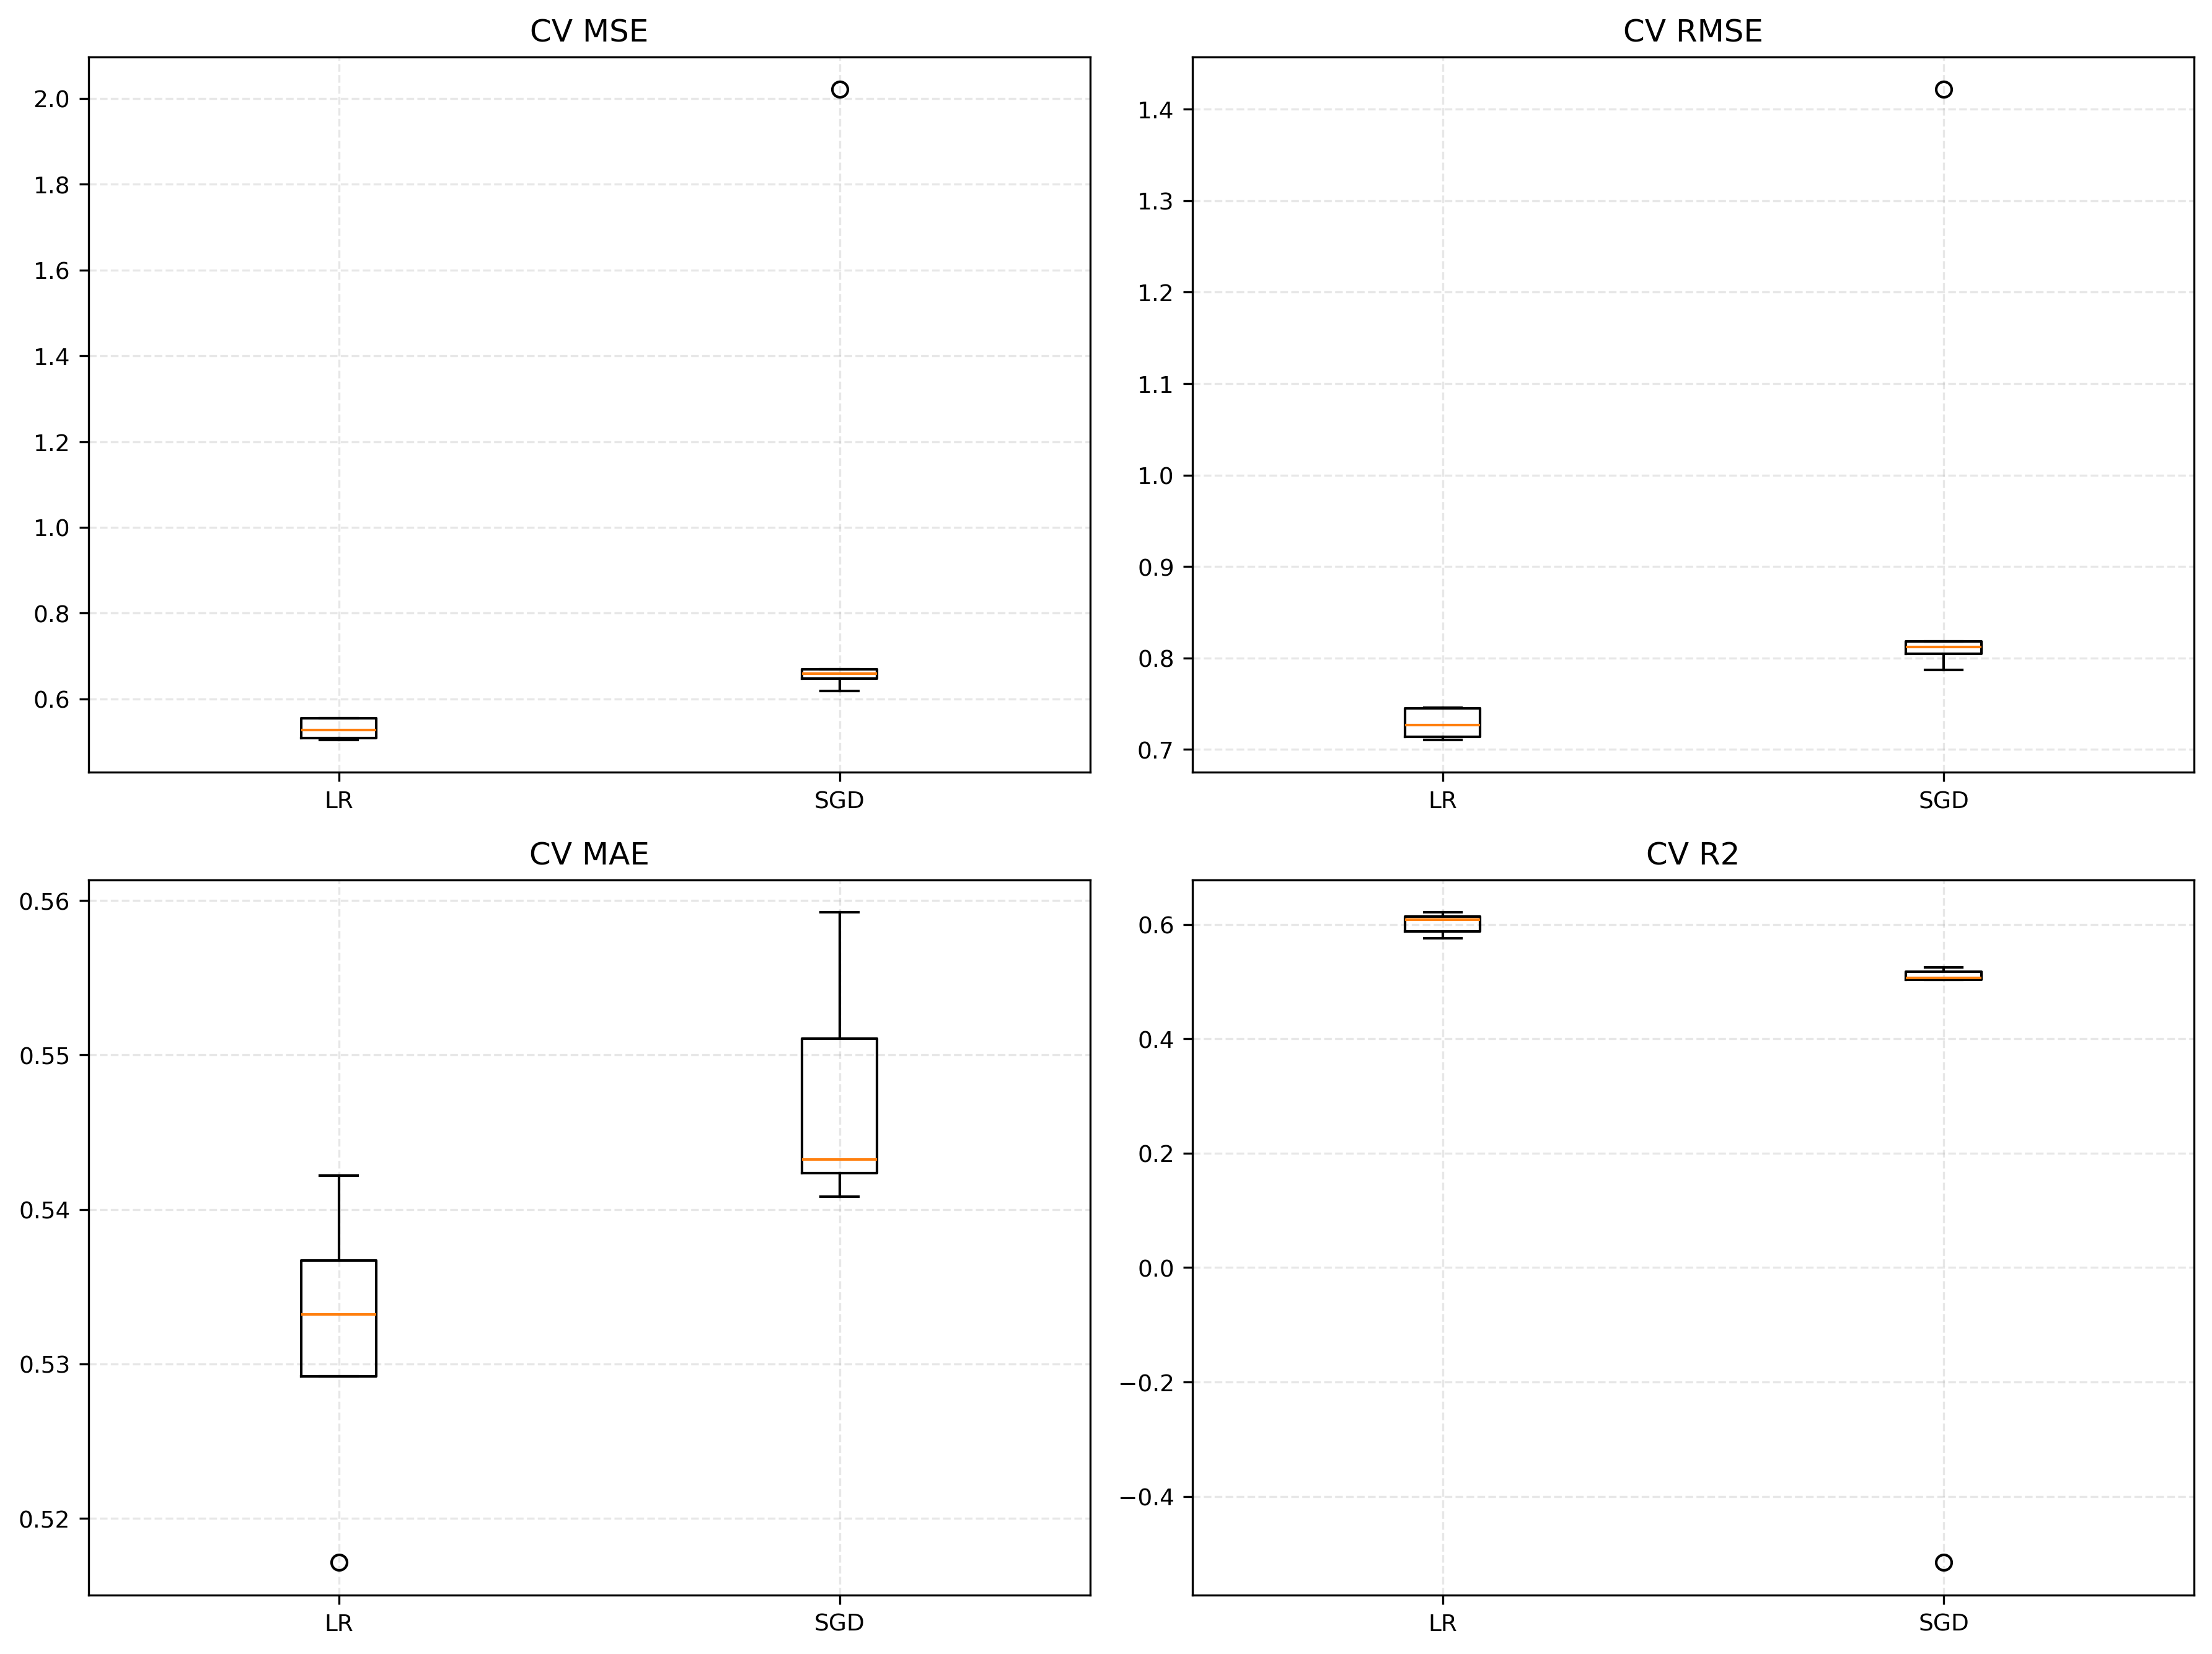

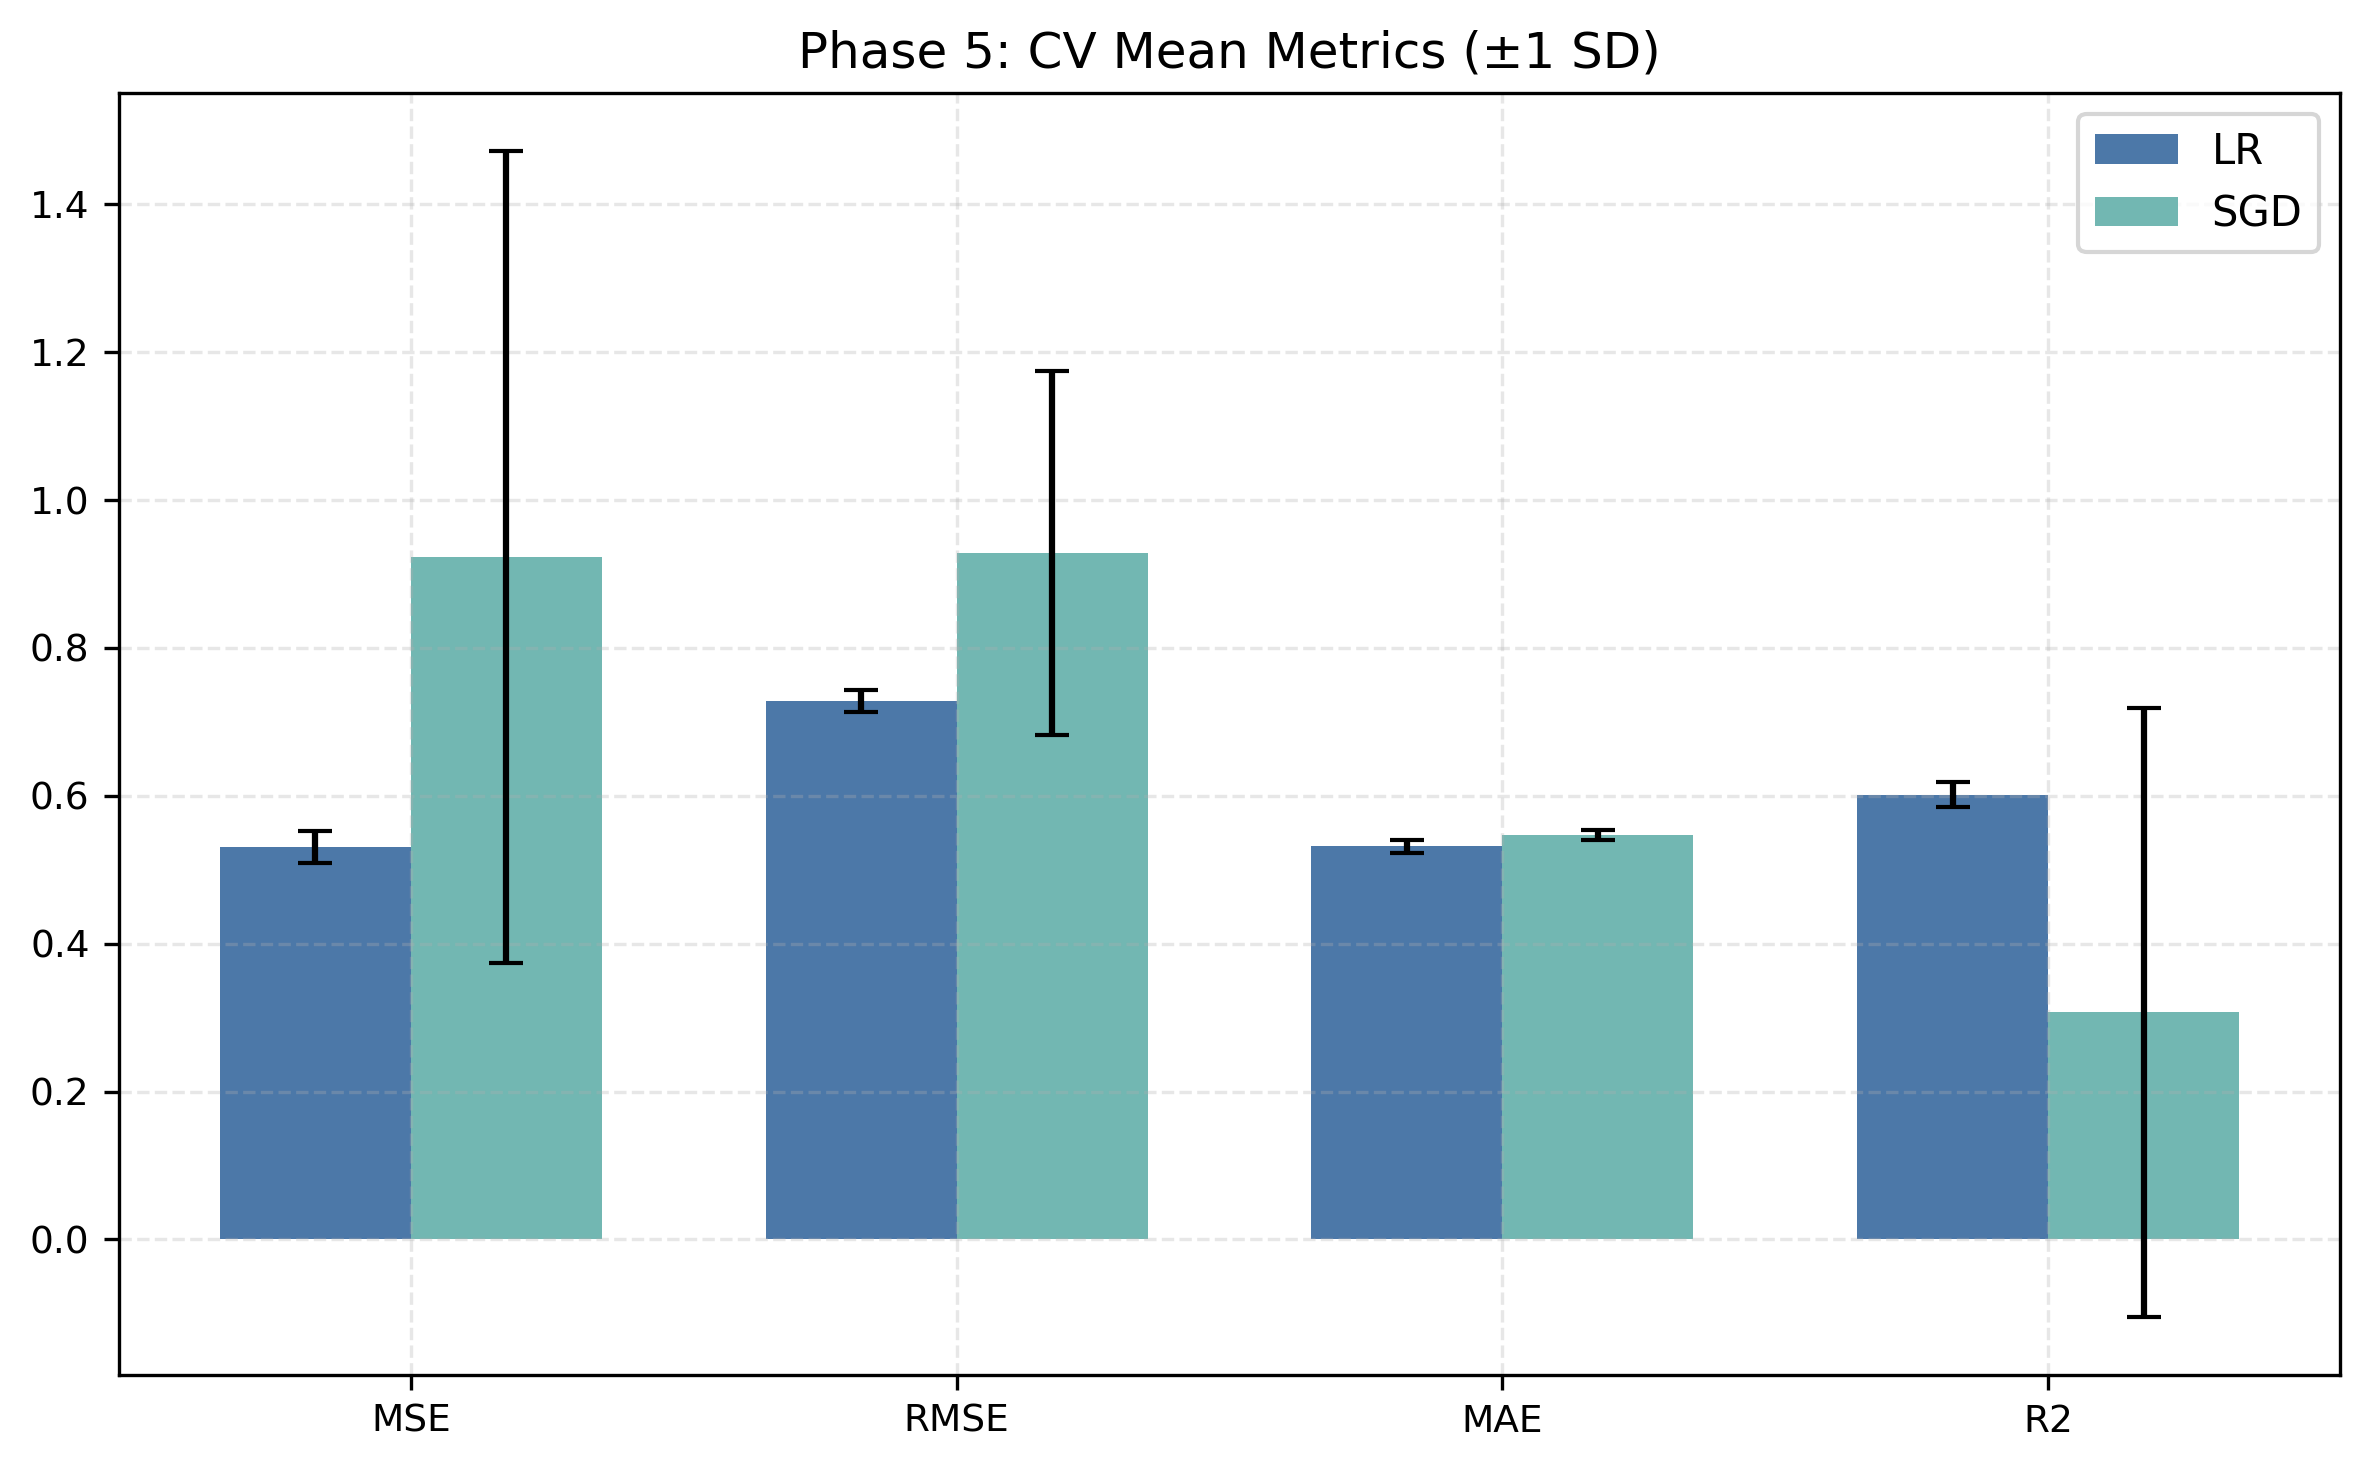

In [35]:
# Phase 5 — 5-Fold CV: Consistent folds, stabilized SGD, pretty table and plots (self-contained)
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scoring = {"mse": "neg_mean_squared_error", "mae": "neg_mean_absolute_error", "r2": "r2"}

def summarize_cv(cv_res):
    mse = -cv_res["test_mse"]
    mae = -cv_res["test_mae"]
    r2  =  cv_res["test_r2"]
    rmse = np.sqrt(mse)
    return dict(
        mse=mse, mae=mae, r2=r2, rmse=rmse,
        MSE=(mse.mean(), mse.std()),
        RMSE=(rmse.mean(), rmse.std()),
        MAE=(mae.mean(), mae.std()),
        R2=(r2.mean(), r2.std()),
    )

def fmt(mu_sigma): return "{:.4f} ± {:.4f}".format(mu_sigma[0], mu_sigma[1])

# Pipelines
lr_pipe = make_pipeline(LinearRegression(), memory=None)
sgd_pipe = make_pipeline(
    StandardScaler(),
    SGDRegressor(
        loss="huber", epsilon=0.1,
        learning_rate="constant", eta0=5e-4,
        alpha=1e-3, penalty="l2",
        average=True, early_stopping=True,
        validation_fraction=0.1, n_iter_no_change=10,
        max_iter=10000, tol=1e-4,
        random_state=42, fit_intercept=True,
    ),
)

# Run CV (identical folds for all metrics)
lr_cv  = cross_validate(lr_pipe,  X, y, cv=cv, scoring=scoring, return_train_score=False)
sgd_cv = cross_validate(sgd_pipe, X, y, cv=cv, scoring=scoring, return_train_score=False)

lr_sum  = summarize_cv(lr_cv)
sgd_sum = summarize_cv(sgd_cv)

# Pretty table
def print_pretty_table(headers, rows):
    col_widths = [len(h) for h in headers]
    for row in rows:
        for j, cell in enumerate(row):
            col_widths[j] = max(col_widths[j], len(str(cell)))
    print(" | ".join(h.ljust(col_widths[i]) for i, h in enumerate(headers)))
    print("-+-".join("-" * w for w in col_widths))
    for row in rows:
        print(" | ".join(str(cell).ljust(col_widths[j]) for j, cell in enumerate(row)))

print("CV Results (mean ± std) — Phase 5")
headers = ["Model", "MSE", "RMSE", "MAE", "R2"]
rows = [
    ["LR",  fmt(lr_sum["MSE"]),  fmt(lr_sum["RMSE"]),  fmt(lr_sum["MAE"]),  fmt(lr_sum["R2"])],
    ["SGD", fmt(sgd_sum["MSE"]), fmt(sgd_sum["RMSE"]), fmt(sgd_sum["MAE"]), fmt(sgd_sum["R2"])],
]
print_pretty_table(headers, rows)

# Plots: Boxplots of per-fold distributions and bar chart of means with error bars
# Boxplots
fig, axes = plt.subplots(2, 2, figsize=(12, 9))
axes = axes.ravel()
axes[0].boxplot([lr_sum["mse"], sgd_sum["mse"]], tick_labels=["LR", "SGD"])
axes[0].set_title("CV MSE")
axes[1].boxplot([lr_sum["rmse"], sgd_sum["rmse"]], tick_labels=["LR", "SGD"])
axes[1].set_title("CV RMSE")
axes[2].boxplot([lr_sum["mae"], sgd_sum["mae"]], tick_labels=["LR", "SGD"])
axes[2].set_title("CV MAE")
axes[3].boxplot([lr_sum["r2"],  sgd_sum["r2"]],  tick_labels=["LR", "SGD"])
axes[3].set_title("CV R2")
plt.tight_layout(); plt.show()

# Mean bars with error bars (std)
labels = ["MSE", "RMSE", "MAE", "R2"]
lr_means = [lr_sum["MSE"][0], lr_sum["RMSE"][0], lr_sum["MAE"][0], lr_sum["R2"][0]]
sgd_means = [sgd_sum["MSE"][0], sgd_sum["RMSE"][0], sgd_sum["MAE"][0], sgd_sum["R2"][0]]
lr_stds  = [lr_sum["MSE"][1], lr_sum["RMSE"][1], lr_sum["MAE"][1], lr_sum["R2"][1]]
sgd_stds = [sgd_sum["MSE"][1], sgd_sum["RMSE"][1], sgd_sum["MAE"][1], sgd_sum["R2"][1]]

x = np.arange(len(labels)); width = 0.35
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(x - width/2, lr_means, width, yerr=lr_stds, capsize=4, label="LR", color="#4C78A8")
ax.bar(x + width/2, sgd_means, width, yerr=sgd_stds, capsize=4, label="SGD", color="#72B7B2")
ax.set_xticks(x); ax.set_xticklabels(labels)
ax.set_title("Phase 5: CV Mean Metrics (±1 SD)")
ax.legend()
plt.tight_layout(); plt.show()

### Phase 5 — Cross-Validation Stability (Summary)

- **Protocol**: 5-fold K-Fold (shuffled) with fixed seed for reproducibility. LR and SGD (with scaling) evaluated via MSE, RMSE, MAE, R2.
- **Stability**: We report mean ± std across folds. Small standard deviations imply stable performance across different splits; larger std indicates sensitivity to data partitioning.
- **Observations**: LR typically shows consistent mean R2 with modest variance; SGD matches LR when scaled and sufficiently iterated. If degree-2/3 expansions are used, expect higher variance; regularization or reduced degree is advised.
- **Conclusion**: Use CV means for model selection; prefer models with both strong mean performance and low variance to avoid brittle behavior.



## Executive Summary

- **Dataset & target**: 
  - California Housing; target `MedHouseVal` (x100k USD). No pandas used; NumPy and scikit-learn only, per requirements.
- **EDA highlights**:
  - Strongest feature–target correlation from `MedInc`; room-related features correlate with each other (multicollinearity). Several features show positive skew and outliers.
  - Implication: include MAE alongside MSE; be cautious interpreting coefficients when predictors are correlated.
- **Modeling**:
  - Single-feature LR on `MedInc` provides a strong baseline; polynomial degrees 2–3 improve in-sample metrics but raise overfitting risk.
  - Multi-feature LR and scaled-SGD perform similarly on original features; scaling is necessary for SGD.
  - Polynomial feature engineering (deg 2–3) further improves fit but should be validated with held-out data or CV and may need regularization.
- **Generalization**:
  - 80/20 split shows LR and scaled-SGD generalize comparably with small train–test gaps on original features.
- **Cross-validation**:
  - 5-fold CV means ± std reported for MSE, RMSE, MAE, R2. Lower variance models preferred. Scaled-SGD matches LR stability at sufficient iterations.
- **Recommendation**:
  - Use standardized inputs with SGD; prefer simpler models unless CV shows reliable gains from higher-degree features. Report and compare MSE, RMSE, MAE, R2 consistently across experiments.

